In [3]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

In [5]:
import numpy as np #    
import matplotlib
import tkinter

import matplotlib.pyplot as plt #                                                              +                        
import cv2
import ipywidgets as widgets
from PIL import ImageEnhance
from PIL import Image # отрисовка изображений

from skimage import io, color
from skimage import util
from IPython.display import display

import matplotlib.image as mpimg 
import os
from tensorflow.keras.preprocessing import image

import pydicom
from skimage.transform import rotate
from skimage.transform import resize
from skimage import exposure
import tifffile

<h1 style="color:red;">NN_700/15(2) - норма (.tiff)</h1>

<h2 style="color:Navy;">1. Создание заданных проекций (оси X,Y,Z, проходящие через кость, взаимно перпендикулярны)</h2>

<h3 style="color:MidnightBlue;">1.1 Создание трехмерноо массива 'volume152' с проверками и преобразованиями при необходимости</h3>

Проверка наличия атрибута ImagePositionPatient перед его использованием.
Использование альтернативных атрибутов: Если ImagePositionPatient отсутствует, упорядочить файлы на основе других атрибутов, таких как InstanceNumber или SliceLocation

In [2]:
directory = 'D:/AleksandrovTI/NN_700/15(2)'
files = [f for f in os.listdir(directory) if f.endswith('.dcm')]
files.sort()

def read_dicom(file_path):
    dcm = pydicom.dcmread(file_path)
    image = dcm.pixel_array
    
    if 'ImagePositionPatient' in dcm:
        position = dcm.ImagePositionPatient
    elif 'InstanceNumber' in dcm:
        position = [0, 0, dcm.InstanceNumber]  # Выделяем позицию по InstanceNumber
    elif 'SliceLocation' in dcm:
        position = [0, 0, dcm.SliceLocation]  # Выделяем позицию по SliceLocation
    else:
        raise AttributeError(f"File {file_path} lacks position information.")
    
    return image, position

# Читаем все DICOM файлы и получаем их позицию и изображение
slices = [read_dicom(os.path.join(directory, f)) for f in files]
slices.sort(key=lambda s: s[1][2])  # Сортируем по Z координате (или ее альтернативе)

# Создаем объемный массив из нормализованных изображений
volume152 = np.stack([s[0] for s in slices], axis=-1)
print(volume152.shape)

(512, 512, 974)


<h3 style="color:MidnightBlue;">1.2 Визуализация по стандартным проекцим</h3>

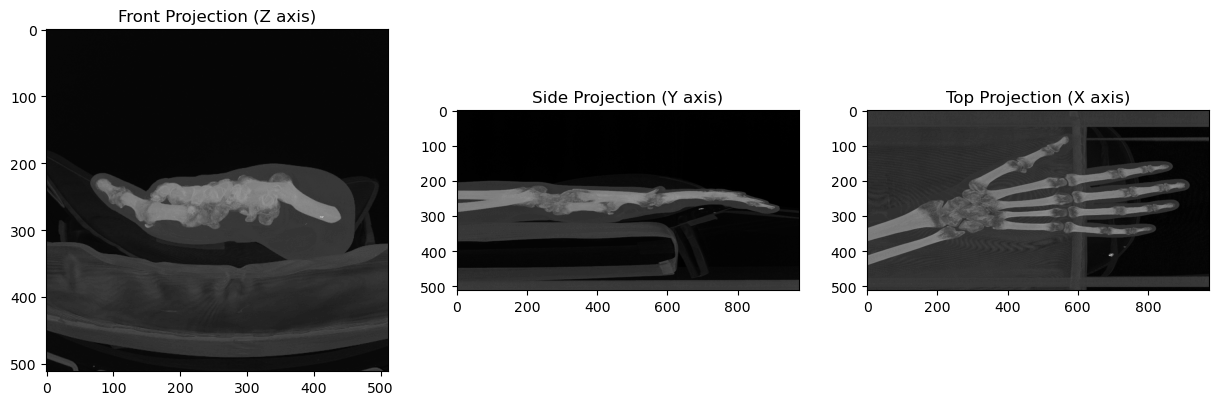

In [3]:
projection_z152 = np.max(volume152, axis=2) # Front projection (по оси Z)
projection_y152 = np.max(volume152, axis=1) # Side projection (по оси Y)
projection_x152 = np.max(volume152, axis=0) # Top projection (по оси X)

fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # Визуализация проекций

axs[0].imshow(projection_z152, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_y152, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_x152, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()

<h3 style="color:MidnightBlue;">1.3 Определение угла между осью исследуемой кости и горизонтом для поворота ПРОЕКЦИИ  X</h3>

In [4]:
# Top projection (по оси X)
projection_x152 = np.max(volume152, axis=0)
tifffile.imwrite('01_projection_x152.tiff', projection_x152) # Сохранение массива в TIFF-файл

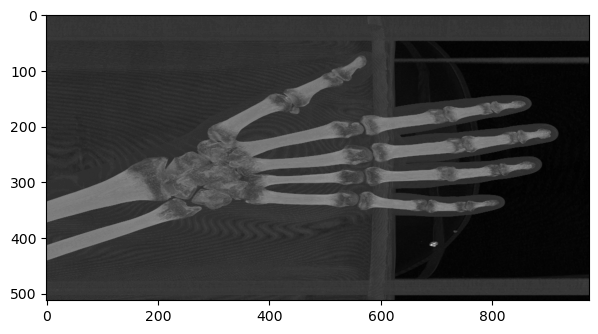

In [5]:
image = tifffile.imread('01_projection_x152.tiff')
plt.figure(figsize=(7, 7))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

In [6]:
imagess = tifffile.imread('01_projection_x152.tiff')
imagesss = np.array(imagess)
imagesss.shape

(512, 974)

<h4 style="color:Blue;">1.3.1 Построение угла</h4>

In [7]:
import cv2
import numpy as np

# Функция для изменения яркости и контрастности изображения
def adjust_brightness_contrast(image, brightness=10, contrast=150):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('01_projection_x152.tiff')
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по указанному пути')

# Коррекция яркости и контрастности
image = adjust_brightness_contrast(image, brightness=40, contrast=450)

# Создание холста для отрисовки линий
overlay = image.copy()

# Список для хранения координат кликов
clicks = []
angles = []  # Список для хранения углов
angle = None  # Глобальная переменная для хранения угла

drawing = False

# Функция для записи угла в файл
def save_angle_to_file(angle, filename='angles.txt'):
    with open(filename, 'a') as f:
        f.write(f'{angle:.2f} градусов\n')

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global clicks, drawing, overlay, angle
    
    if event == cv2.EVENT_LBUTTONDOWN:
        clicks.append((x, y))

        if len(clicks) == 2:
            # Построить прямую линию №1, проходящую через ВСЁ изображение
            p1, p2 = clicks
            slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
            intercept = p1[1] - slope * p1[0]

            x_coords = np.array([0, image.shape[1]])
            y_coords = slope * x_coords + intercept
            cv2.line(overlay, (x_coords[0], int(y_coords[0])), (x_coords[1], int(y_coords[1])), (255, 0, 0), 2)
            
            drawing = True

            # Вычисление угла между линией №1 и горизонтом
            angle = np.degrees(np.arctan2(slope, 1))

            # Проверка положения горизонтальной линии относительно линии №1
            if p1[1] < y_coords[0]:
                # Горизонтальная линия выше линии №1
                angle = abs(angle)
            else:
                # Горизонтальная линия ниже линии №1
                angle = -abs(angle)

            angles.append(angle)

            print(f'Угол между линией №1 и горизонтом: {angle:.2f} градусов')

            # Вывод угла на изображение
            cv2.putText(overlay, f"{angle:.2f} deg", (10, image.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            save_angle_to_file(angle)  # Запись угла в файл

        elif len(clicks) == 3:
            # Построить горизонтальную линию через третий клик
            p3 = clicks[2]
            cv2.line(overlay, (0, p3[1]), (image.shape[1], p3[1]), (0, 255, 0), 2)
            print(f'Горизонтальная линия нарисована через точку: {p3}')

# Привязка обработчика событий к окну изображения
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения с наложенными линиями
while True:
    cv2.imshow('Изображение', overlay)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

# Сохранение измененного изображения
cv2.imwrite('02_projection_x152_angle.tiff', overlay)

cv2.destroyAllWindows()

print(f'Углы, сохраненные в программе: {angles}')


Угол между линией №1 и горизонтом: 16.80 градусов
Углы, сохраненные в программе: [16.80027706793378]


In [8]:
print(angle)

16.80027706793378


In [9]:
a1 = angle
a1

16.80027706793378

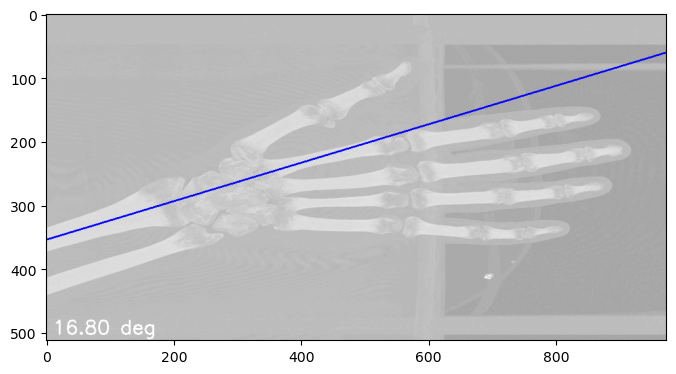

In [10]:
image1 = tifffile.imread('02_projection_x152_angle.tiff')
plt.figure(figsize=(8, 8))
plt.imshow(image1, cmap='gray')
#plt.axis('off')
plt.show()

<h3 style="color:MidnightBlue;">1.4 Поворот плоскостей вокруг оси Z с заданным углом поворота - получение  'rotated_volume282'</h3>

Original volume shape: (512, 512, 974)
Rotated volume shape: (512, 512, 974)


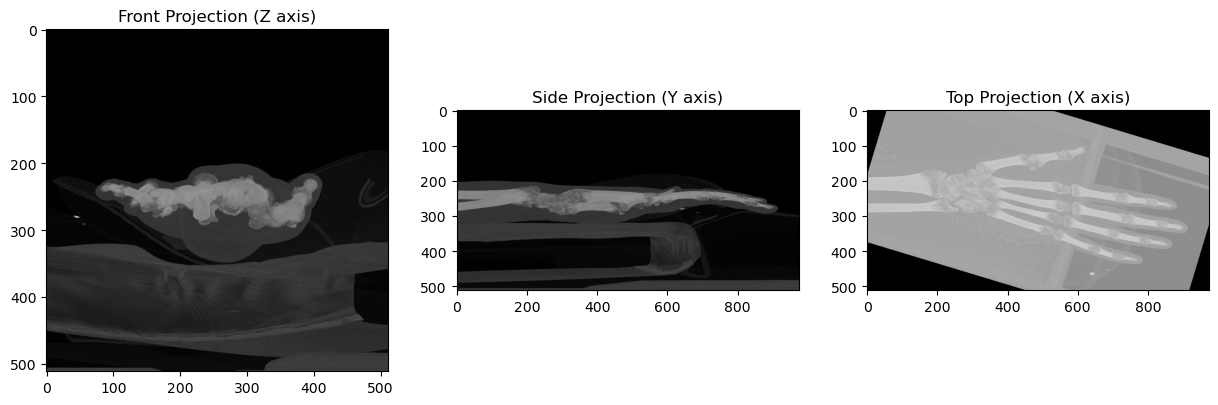

In [11]:
import os
import numpy as np
import pydicom
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

def read_dicom_images(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    files.sort()
    slices = [pydicom.dcmread(f).pixel_array for f in files]
    volume = np.stack(slices, axis=-1)
    return volume

def rotate_volume(volume, angle):
    # Поворот объёма вокруг оси Z
    rotated_volume = rotate(volume, angle, axes=(1, 2), reshape=False)
    return rotated_volume

def get_projections(volume):
    projection_xx = np.flip(np.max(volume, axis=0), axis=1)
    projection_yy = np.flip(np.max(volume, axis=1), axis=1)
    projection_zz = np.flip(np.max(volume, axis=2), axis=1)
    return projection_xx, projection_yy, projection_zz

# Путь к директории с DICOM изображениями
directory = 'D:/AleksandrovTI/NN_700/15(2)'

# Чтение и нормализация изображения
volume = read_dicom_images(directory)
#volume_normalized = normalize_images(volume)
print("Original volume shape:", volume.shape)

# Угол поворота 
angle = a1

# Поворот объёма вокруг оси Z
rotated_volume152 = rotate_volume(volume, angle)
print("Rotated volume shape:", rotated_volume152.shape)

# Получение проекций после поворота
projection_xr, projection_yr, projection_zr = get_projections(rotated_volume152)

# Визуализация проекций
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(projection_zr, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_yr, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_xr, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()


<h3 style="color:MidnightBlue;">1.5 Определение угла между осью исследуемой кости и горизонтом для поворота ПРОЕКЦИИ Y</h3>

In [12]:
# Side Projection (Y axis)
projection_yr152 = np.max(rotated_volume152, axis=1)
projection_yr152 = np.flip(projection_yr152, axis=1) # ИСПРАВЛЕНИЕ ВЫВОДА ЗЕРКАЛЬНОГО ИЗОБРАЖЕНИЯ
tifffile.imwrite('03_projection_yr152.tiff', projection_yr152)

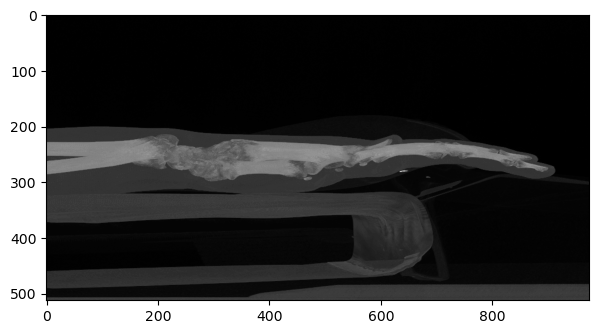

In [13]:
image = tifffile.imread('03_projection_yr152.tiff')
plt.figure(figsize=(7, 7))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Blue;">1.5.1 Построение угла</h4>

In [20]:
import cv2
import numpy as np

# Функция для изменения яркости и контрастности изображения
def adjust_brightness_contrast(image, brightness=10, contrast=150):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('03_projection_yr152.tiff')
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по указанному пути')

# Коррекция яркости и контрастности
image = adjust_brightness_contrast(image, brightness=40, contrast=450)

# Создание холста для отрисовки линий
overlay = image.copy()

# Список для хранения координат кликов
clicks = []
angles = []  # Список для хранения углов
angle = None  # Глобальная переменная для хранения угла

drawing = False

# Функция для записи угла в файл
def save_angle_to_file(angle, filename='angles.txt'):
    with open(filename, 'a') as f:
        f.write(f'{angle:.2f} градусов\n')

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global clicks, drawing, overlay, angle
    
    if event == cv2.EVENT_LBUTTONDOWN:
        clicks.append((x, y))

        if len(clicks) == 2:
            # Построить прямую линию №1, проходящую через ВСЁ изображение
            p1, p2 = clicks
            slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
            intercept = p1[1] - slope * p1[0]

            x_coords = np.array([0, image.shape[1]])
            y_coords = slope * x_coords + intercept
            cv2.line(overlay, (x_coords[0], int(y_coords[0])), (x_coords[1], int(y_coords[1])), (255, 0, 0), 2)
            
            drawing = True

            # Вычисление угла между линией №1 и горизонтом
            angle = np.degrees(np.arctan2(slope, 1))

            # Проверка положения горизонтальной линии относительно линии №1
            if p1[1] < y_coords[0]:
                # Горизонтальная линия выше линии №1
                angle = abs(angle)
            else:
                # Горизонтальная линия ниже линии №1
                angle = -abs(angle)

            angles.append(angle)

            print(f'Угол между линией №1 и горизонтом: {angle:.2f} градусов')

            # Вывод угла на изображение
            cv2.putText(overlay, f"{angle:.2f} deg", (10, image.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            save_angle_to_file(angle)  # Запись угла в файл

        elif len(clicks) == 3:
            # Построить горизонтальную линию через третий клик
            p3 = clicks[2]
            cv2.line(overlay, (0, p3[1]), (image.shape[1], p3[1]), (0, 255, 0), 2)
            print(f'Горизонтальная линия нарисована через точку: {p3}')

# Привязка обработчика событий к окну изображения
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения с наложенными линиями
while True:
    cv2.imshow('Изображение', overlay)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

# Сохранение измененного изображения
cv2.imwrite('04_projection_yr152_angle.tiff', overlay)

cv2.destroyAllWindows()

print(f'Углы, сохраненные в программе: {angles}')


Угол между линией №1 и горизонтом: -1.25 градусов
Углы, сохраненные в программе: [-1.2453642667683473]


In [21]:
angle

-1.2453642667683473

In [22]:
b1 = angle
b1

-1.2453642667683473

In [23]:
a1

16.80027706793378

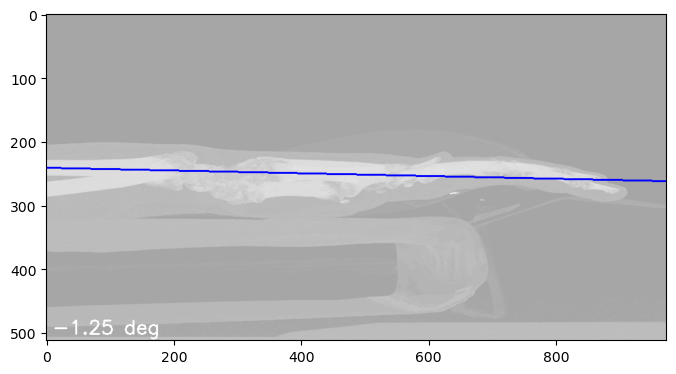

In [24]:
image1 = tifffile.imread('04_projection_yr152_angle.tiff')
plt.figure(figsize=(8, 8))
plt.imshow(image1, cmap='gray')
#plt.axis('off')
plt.show()

<h3 style="color:MidnightBlue;">1.6 Поворот плоскостей вокруг оси Y с заданным углом поворота - получение  'twice_rotated_volume152'</h3>

Rotated volume shape: (512, 512, 974)


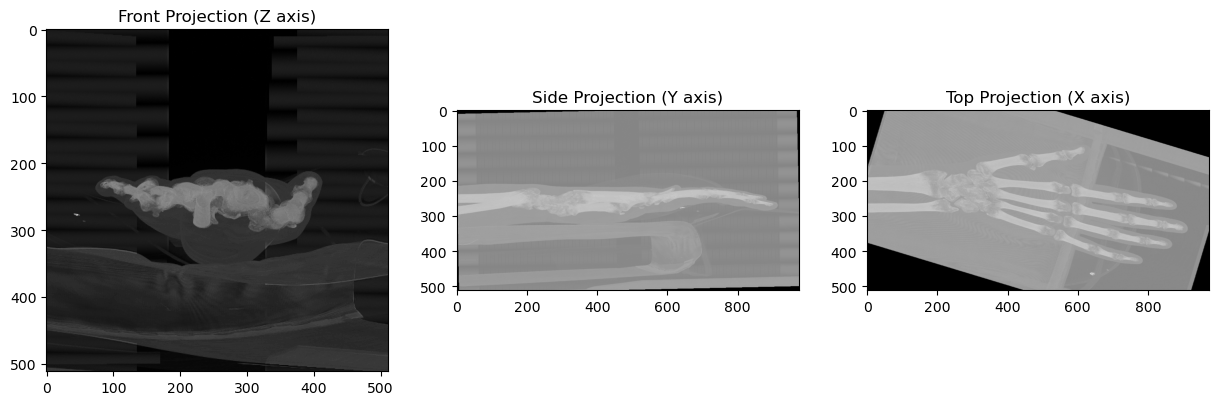

In [25]:
import os
import numpy as np
import pydicom
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

def read_dicom_images(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    files.sort()
    slices = [pydicom.dcmread(f).pixel_array for f in files]
    volume = np.stack(slices, axis=-1)
    return volume

def rotate_volume(volume, angle):
    # Поворот объёма вокруг оси Z
    rotated_volume = rotate(volume, angle, axes=(0, 2), reshape=False)
    return rotated_volume

def get_projections(volume):
    projection_xxx = np.flip(np.max(volume, axis=0), axis=1)
    projection_yyy = np.flip(np.max(volume, axis=1), axis=1)
    projection_zzz = np.flip(np.max(volume, axis=2), axis=1)
    return projection_xxx, projection_yyy, projection_zzz

# Угол поворота 
angle = b1

# Поворот объёма вокруг оси Y
twice_rotated_volume152 = rotate_volume(rotated_volume152, angle)
print("Rotated volume shape:", twice_rotated_volume152.shape)

# Получение проекций после ВТОРОГО поворота
projection_xrr, projection_yrr, projection_zrr = get_projections(twice_rotated_volume152)

# Визуализация проекций
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(projection_zrr, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_yrr, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_xrr, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()


<h3 style="color:MidnightBlue;">1.7 Вывод проекции Х в twice_rotated_volume152 и определения ВЕРТИКАЛЬНОЙ координаты сечения массива</h3>

In [26]:
projection_xrr152 = np.max(twice_rotated_volume152, axis=0)
projection_xrr152 = np.flip(projection_xrr152, axis=1)
tifffile.imwrite('05_projection_xrr152.tiff', projection_xrr152)

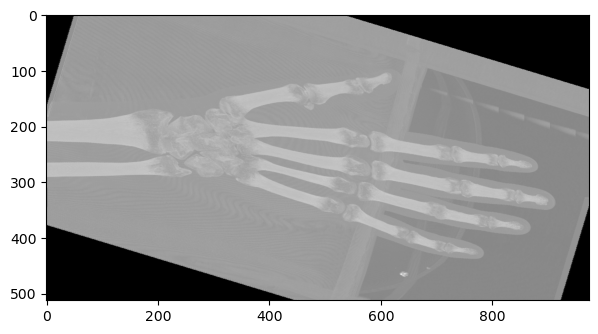

In [27]:
# Отображение изображения
image = tifffile.imread('05_projection_xrr152.tiff')
plt.figure(figsize=(7, 7))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Blue;">1.7.1 Определениt ВЕРТИКАЛЬНОЙ координаты сечения  массива</h4>

In [28]:
def adjust_brightness_contrast(image, brightness=50, contrast=50):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('05_projection_xrr152.tiff')

# Функция-обработчик события клика мыши
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Координаты сечения по клику выбранной кости: ({x}, {y})")
        
def apply_clahe(img):
    # Создаем объект CLAHE ПОВЫШЕНИЯ КОНТРАСТНОСТИ
    clahe = cv2.createCLAHE(clipLimit = 10.0, tileGridSize=(8, 8))
    
    # Если изображение цветное, применяем CLAHE для каждого канала YUV
    if len(img.shape) == 3 and img.shape[2] == 3:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        img_clahe = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    elif len(img.shape) == 2:  # Если изображение одноцветное
        img_clahe = clahe.apply(img)
    else:
        img_clahe = img
    
    return img_clahe

# Создание окна и привязка обработчика события
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Применение CLAHE для улучшения контраста
img_clahe = apply_clahe(image)


# Отображение изображения
while True:
    cv2.imshow('Изображение', img_clahe)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

Координаты сечения по клику выбранной кости: (17, 210)


<h4 style="color:Blue;">1.7.2 Изображение с ценой деления 10 для уточнения координаты</h4>

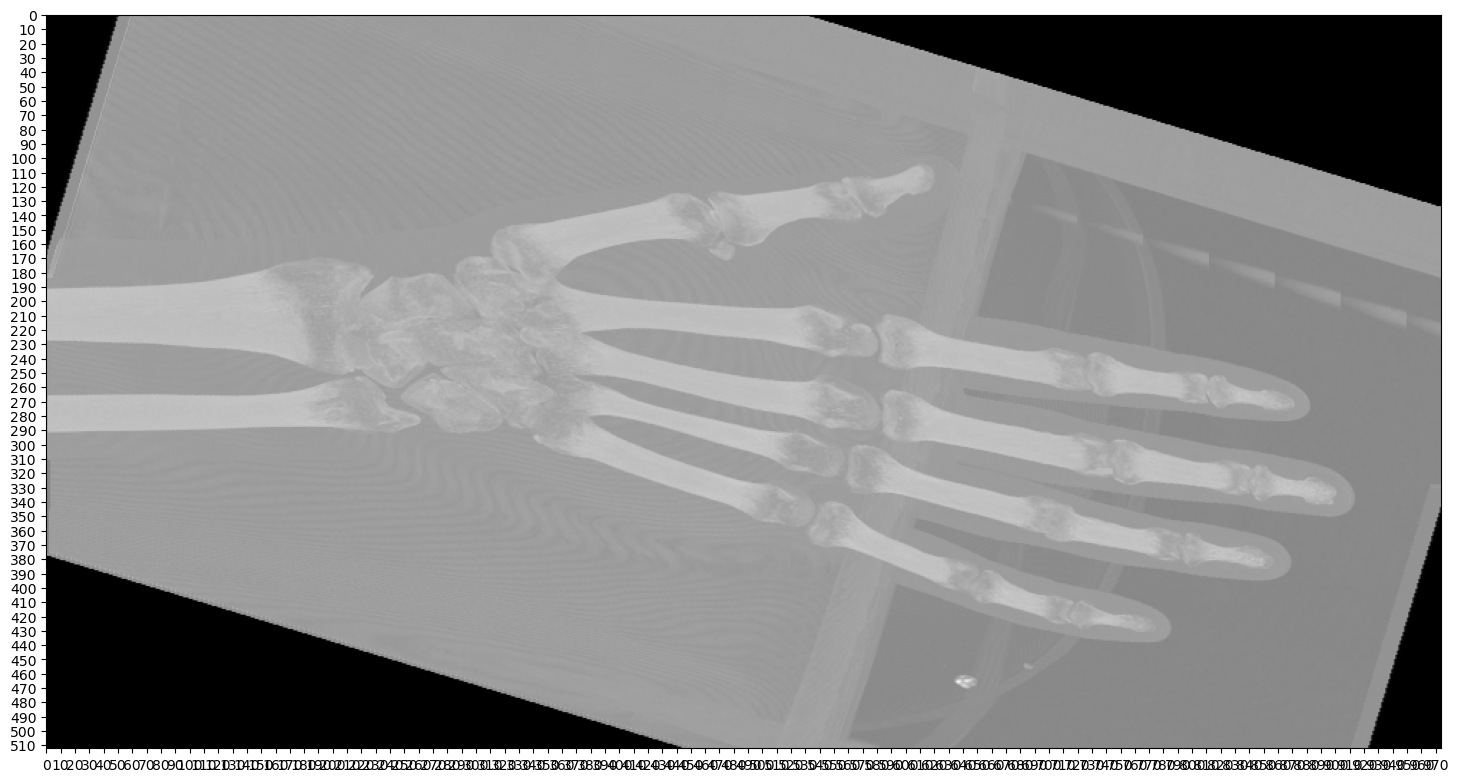

In [29]:
gray_image = mpimg.imread('05_projection_xrr152.tiff')

# Создание фигуры и осей
#fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(18, 12))  # Увеличенный размер холста
# Отображение изображения
ax.imshow(gray_image, cmap='gray', extent=[0, gray_image.shape[1], gray_image.shape[0], 0])

# Настройка тиков по осям x и y с шагом 20
ax.set_xticks(np.arange(0, gray_image.shape[1], 10))
ax.set_yticks(np.arange(0, gray_image.shape[0], 10))

# Показ графика
plt.show()

<h3 style="color:MidnightBlue;">1.8 Транспонирования, flip, получение сечения</h3>

In [30]:
vol = np.transpose(twice_rotated_volume152, (1, 2, 0))
vol.shape

(512, 974, 512)

In [31]:
pictmono = vol[210]
pictmono.shape

(974, 512)

In [32]:
pictmono1 = np.transpose(pictmono, (1, 0))
flipped_mono = np.flip(pictmono1, axis=1)
print(f"Исходный массив: {pictmono.shape}")
print(f"Преобразованный массив: {flipped_mono.shape}")

Исходный массив: (974, 512)
Преобразованный массив: (512, 974)


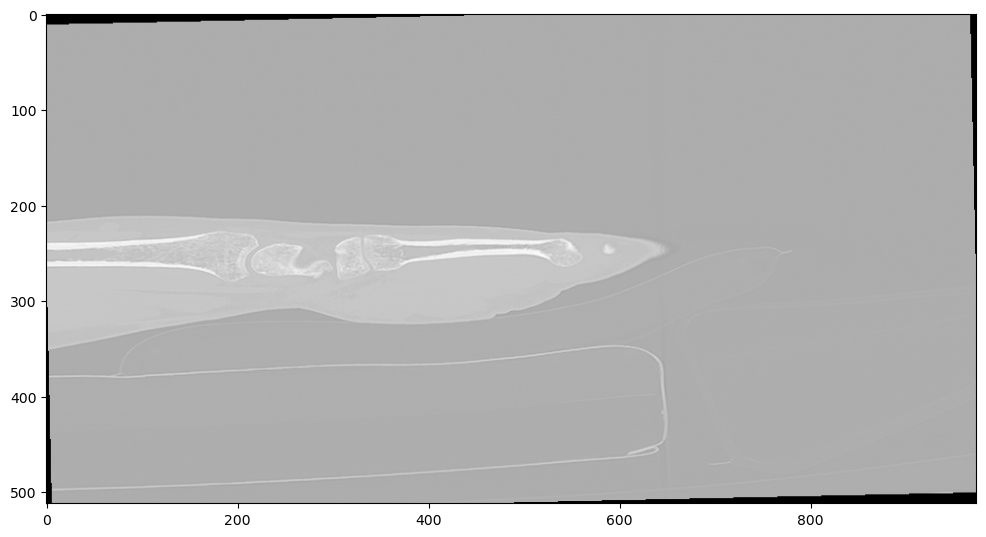

In [33]:
tifffile.imwrite('06_from_pictmono_xrr152.tiff', flipped_mono)
image = tifffile.imread('06_from_pictmono_xrr152.tiff')
plt.figure(figsize=(12, 12))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h3 style="color:MidnightBlue;">1.9 Определение на вертикальном сечении проекции "projection_yrr" координату сечения горизонтальной плоскостью</h3>

In [34]:
def adjust_brightness_contrast(image, brightness=50, contrast=50):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('06_from_pictmono_xrr152.tiff')
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по пути')

# Коррекция яркости и контрастности
image = adjust_brightness_contrast(image, brightness=40, contrast=450)

# Функция-обработчик события клика мыши
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Координаты сечения по клику выбранной кости: ({x}, {y})")

# Создание окна и привязка обработчика события
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения
while True:
    cv2.imshow('Изображение', image)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

Координаты сечения по клику выбранной кости: (67, 251)


<h3 style="color:MidnightBlue;">1.10 Сечение массива второго поворота "twice_rotated_volume152" плоскостями на высоте 252,254,256</h3>

In [35]:
twice_rotated_volume152.shape

(512, 512, 974)

In [36]:
pictt1 = twice_rotated_volume152[249]
# Зеркальное отражение изображения слева направо
#flipped_pictt1 = np.flip(pictt1, axis=1)
flipped_pictt11 = np.transpose(pictt1, (1, 0))

In [37]:
pictt2 = twice_rotated_volume152[251]
# Зеркальное отражение изображения слева направо
#flipped_pictt2 = np.flip(pictt2, axis=1)
flipped_pictt22 = np.transpose(pictt2, (1, 0))

In [38]:
pictt3 = twice_rotated_volume152[253]
# Зеркальное отражение изображения слева направо
#flipped_pictt3 = np.flip(pictt3, axis=1)
flipped_pictt33 = np.transpose(pictt3, (1, 0))

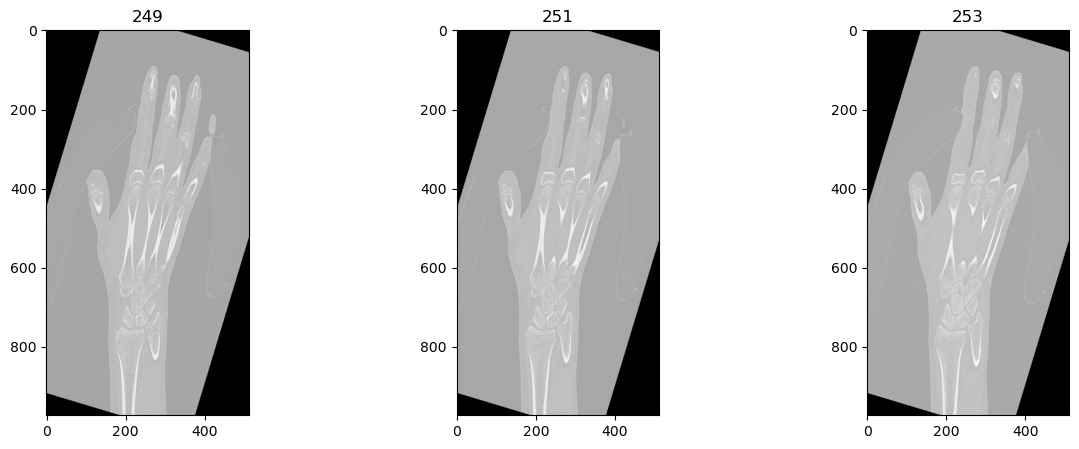

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # Визуализация проекций

axs[0].imshow(flipped_pictt11, cmap='gray')
axs[0].set_title('249')

axs[1].imshow(flipped_pictt22, cmap='gray')
axs[1].set_title('251')

axs[2].imshow(flipped_pictt33, cmap='gray')
axs[2].set_title('253')

plt.show()

<h4 style="color:Blue;">1.10.1 Обрезка изображений</h4>

In [40]:
tifffile.imwrite('15_249_152.tiff', flipped_pictt11) # Сохранение массива в TIFF-файл
tifffile.imwrite('15_251_152.tiff', flipped_pictt22) # Сохранение массива в TIFF-файл
tifffile.imwrite('15_253_152.tiff', flipped_pictt33) # Сохранение массива в TIFF-файл

#### 249

In [41]:
image = Image.open('15_249_152.tiff')

# размеры для обрезки
left = 150
top = 550
right = 150
bottom = 50

cropped_image = image.crop((left, top, image.width - right, image.height - bottom))

cropped_image.save('16_249_152_bw.tiff')

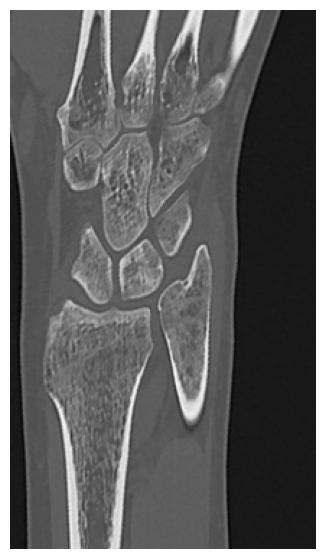

In [42]:
%matplotlib inline
gray_image282 = Image.open('16_249_152_bw.tiff')
plt.figure(figsize=(7, 7)) # Отображение изображения в оттенках серого
plt.imshow(gray_image282, cmap='gray')
plt.axis('off')
plt.show()

#### 251

In [45]:
image = Image.open('15_251_152.tiff')

# размеры для обрезки
left = 150
top = 550
right = 150
bottom = 50

cropped_image = image.crop((left, top, image.width - right, image.height - bottom))

cropped_image.save('16_251_152_bw.tiff')

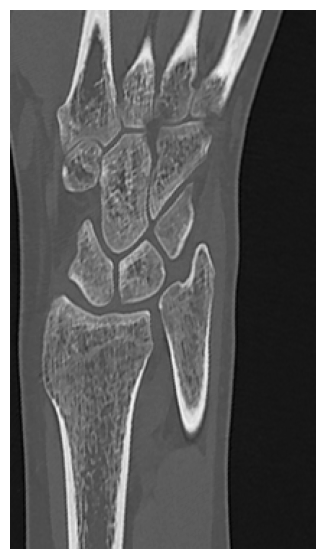

In [46]:
%matplotlib inline
gray_image152 = Image.open('16_251_152_bw.tiff')
plt.figure(figsize=(7, 7)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
plt.axis('off')
plt.show()

#### 253

In [47]:
image = Image.open('15_253_152.tiff')

# размеры для обрезки
left = 150
top = 550
right = 150
bottom = 50

cropped_image = image.crop((left, top, image.width - right, image.height - bottom))

cropped_image.save('16_253_152_bw.tiff')

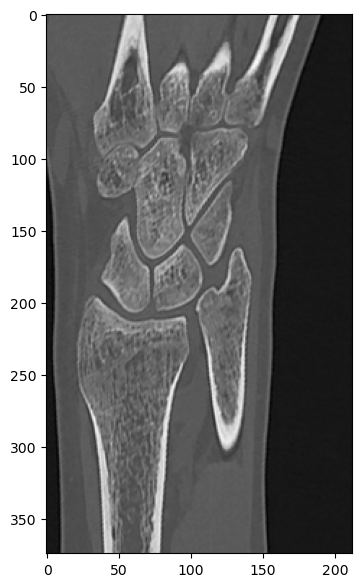

In [48]:
%matplotlib inline
gray_image152 = Image.open('16_253_152_bw.tiff')
plt.figure(figsize=(7, 7)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
#plt.axis('off')
plt.show()

In [51]:
imagett = tifffile.imread('16_253_152_bw.tiff')
#imagettt = np.array(imagett)
imagett.shape

(374, 212)

In [52]:
print(imagett.min())
print(imagett.max())

6838
10807


<h3 style="color:MidnightBlue;">1.11 Сечение "16_253_152_bw.tiff" как предствитель класса HEALTHY</h3>

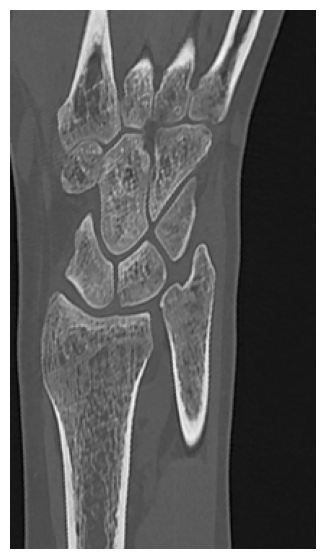

In [53]:
%matplotlib inline
gray_image282 = Image.open('16_253_152_bw.tiff')
plt.figure(figsize=(7, 7)) # Отображение изображения в оттенках серого
plt.imshow(gray_image282, cmap='gray')
plt.axis('off')
plt.show()

<h2 style="color:Crimson;">3.2 Замкнутая линия и df</h2>

In [54]:
image_path = '16_253_152_bw.tiff'
image = Image.open(image_path)
# Проверяем, в каком формате открыто изображение
print(image.mode) 

I;16


In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

### Перевод в 8 битную - потеря деталей озображения с сохранением tiff

In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from PIL import Image, ImageDraw
import pandas as pd
import matplotlib
import tifffile

matplotlib.use('TkAgg')  # Используйте TkAgg backend
from matplotlib.backend_bases import MouseButton

df = pd.DataFrame(columns=['pixels_inside_curve'])

image_path = '16_253_152_bw.tiff'  # Путь к изображению
image_array = tifffile.imread(image_path)  # Чтение изображения в numpy массив
image_array = image_array.astype(np.int32)
# Преобразование numpy массива в объект PIL Image для дальнейшего использования
image = Image.fromarray(image_array).convert("RGBA")

# Определение размера изображения
height, width = [374,212]

# список для хранения точек
points = []

def onclick(event):
    line_image = create_line_image()
    save_combined_image(line_image)

# Обработчик кликов
def onclick(event):
    global points
    if event.button == MouseButton.LEFT:
        # Добавление точки в список
        points.append([event.xdata, event.ydata])
        
        # Отображение точки на изображении
        ax.plot(event.xdata, event.ydata, 'ro', markersize=3)
        fig.canvas.draw()
        
        # Когда было выбрано 31 точек или больше, нарисовать кривую линию
        if len(points) == 41:
            if points[0] != points[-1]:
                points.append(points[0])
            line_image = draw_spline(points)  # Теперь передаем line_image
            save_combined_image(line_image)
            save_line_image(line_image)  # Добавляем этот вызов
            save_internal_pixels_list(points, width, height)  # Передаем ширину и высоту
            fig.canvas.mpl_disconnect(cid)

# Функция для рисования кривой линии
def draw_spline(points):
    points = np.array(points)
    x = points[:, 0]
    y = points[:, 1]
    
    # Используем сплайны для плавной линии через контрольные точки
    tck, u = splprep([x, y], s=0)
    u_new = np.linspace(u.min(), u.max(), 1000)
    x_new, y_new = splev(u_new, tck, ext=0)
    
    ax.plot(x_new, y_new, 'r-', lw=1.2)  # Рисование линии
    fig.canvas.draw()

    # Создаем пустое изображение для линии
    line_image = Image.new("RGBA", (width, height), (0, 0, 0, 0))
    save_combined_image(line_image)
    draw = ImageDraw.Draw(line_image)
    line_points = list(zip(x_new, y_new))
    draw.line(line_points, fill=(255, 0, 0, 255), width=1)
    return line_image

# Функция для сохранения изображения с нанесённой линией
def save_combined_image(line_image):
    # Копируем исходное изображение
    combined_image = image.copy()
    combined_image = Image.alpha_composite(combined_image, line_image)
    combined_image.save("16_250_152_bw_1_line.png")
    #print("Изображение сохранено как 16_256_152_gilula_and_1_line.png")
    
# Функция для сохранения только линии в отдельный файл
def save_line_image(line_image):
    line_image.save("first_line_only.tiff")
    #print("Изображение линии сохранено как first_line_only.png")

# Функция для сохранения списка пикселей внутри замкнутой кривой линии
def save_internal_pixels_list(points, width, height):
    mask = Image.new("L", (width, height), 0)
    points = [(int(p[0]), int(p[1])) for p in points]
    ImageDraw.Draw(mask).polygon(points, outline=1, fill=1)
    mask = np.array(mask)
    
    internal_pixels = image_array[mask == 1]
    
    # Добавление списка пикселей в DataFrame
    df.loc[len(df)] = [internal_pixels.tolist()]
    print("Пиксели внутри замкнутой кривой линии добавлены в DataFrame")
    print(df)

# Создание фигуры и отображение изображения
fig, ax = plt.subplots()
ax.imshow(image_array)

# Привязка обработчика кликов
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# Запуск обработки событий и отображение окна
plt.show()

Пиксели внутри замкнутой кривой линии добавлены в DataFrame
                                 pixels_inside_curve
0  [8433, 8290, 8446, 8506, 8318, 8413, 8966, 854...


In [47]:
df

pixels_inside_curve
0  [8433, 8290, 8446, 8506, 8318, 8413, 8966, 854...

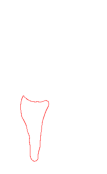

In [48]:
%matplotlib inline
gray_image152 = mpimg.imread('16_250_152_bw_1_line.png')
plt.figure(figsize=(2, 2)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
plt.axis('off')
plt.show()

<h3 style="color:blue;">4.2 Количество и значения пикселей на ограниченном линией участке</h3>

In [49]:
# Каличество пикселей
len(df.iloc[0,0])

5723

In [50]:
# СПИСОК
listic250 = df.iloc[0,0] # Список элементов
print(listic250[0:10])
print(min(listic250))
print(max(listic250))

[8433, 8290, 8446, 8506, 8318, 8413, 8966, 8541, 8531, 8504]
7809
9638


In [51]:
import pickle
with open('listic250.pkl', 'wb') as f:
    pickle.dump(listic250, f)

In [52]:
import pickle
# Загрузка из pickle-файла
with open('listic250.pkl', 'rb') as f:
    listic250 = pickle.load(f)

<h2 style="color:Blue;">12.1 Представление распределения вырезанной части изображения listic250</h2>

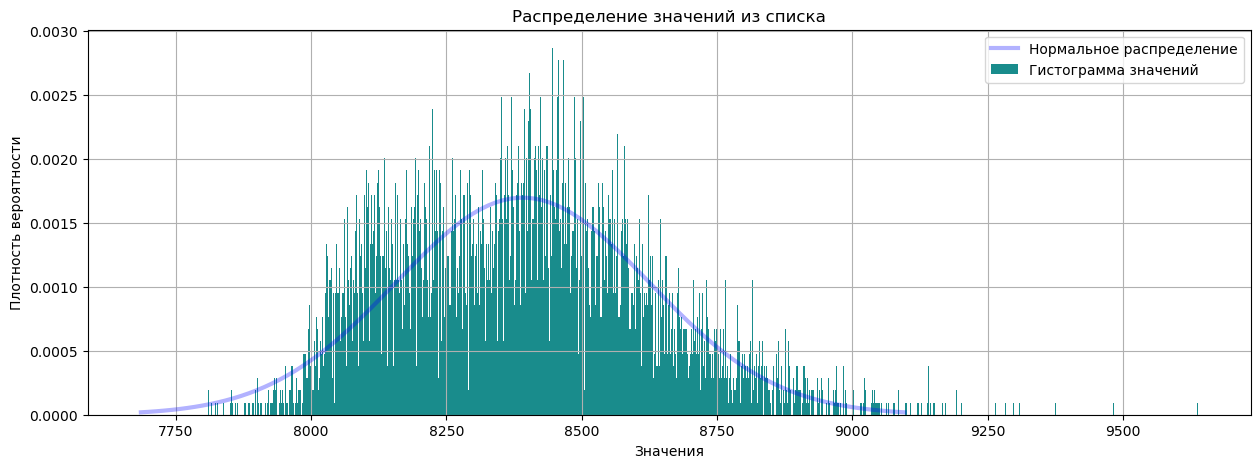

Эксцесс  0.11855876565862244
Асимметрия  0.4203990551908597
Среднее значение пикселей: 8390.877162327452
Минимальное значение пикселей: 7809
Минимальное значение пикселей: 9638
Три наиболее часто встречающихся значения:
Значение: 8404, Частота: 19
Значение: 8498, Частота: 18
Значение: 8425, Частота: 18


In [53]:
from collections import Counter
from scipy.stats import kurtosis
from scipy.stats import skew
import statistics
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
# Вычисление среднего и стандартного отклонения
mean = np.mean(listic250) ######################################################################
std_dev = np.std(listic250) ###############################################################################

# Генерация точек для построения нормального распределения
x = np.linspace(mean -3*std_dev, mean + 3*std_dev, 100)
y = stats.norm.pdf(x, mean, std_dev)


# Построение графика
plt.figure(figsize=(15, 5))
plt.plot(x, y, linewidth=3, color='b', label='Нормальное распределение', alpha=0.3)
plt.hist(listic250, density=True, bins=1000, alpha=0.9, color='Teal', label='Гистограмма значений') ############################


plt.title('Распределение значений из списка')
plt.xlabel('Значения')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid()
plt.show()
print("Эксцесс ", kurtosis(listic250))######################################################
print("Асимметрия ", skew(listic250))####################################################

average = statistics.mean(listic250) #####################################################
print(f'Среднее значение пикселей: {average}') 

mi = min(listic250)##################################################################
print(f'Минимальное значение пикселей: {mi}') 
ma = max(listic250)###################################################################
print(f'Минимальное значение пикселей: {ma}') 

count = Counter(listic250)  ##################################################################
# Получение трех наиболее распространенных значений и их частоты
most_common_three = count.most_common(3)
print("Три наиболее часто встречающихся значения:")
for value, freq in most_common_three:
    print(f'Значение: {value}, Частота: {freq}')


<h4 style="color:Blue;">Уникальных значкеий в списке</h4>

In [54]:
unique_values = set(listic250)
len(unique_values)

1045

<h4 style="color:Blue;">Отношение объема пересечения к объему объединения гистограммы и её нормального распределения (unhealthy)</h4>

Отношение объема пересечения к объему объединения: 0.8712387712101676


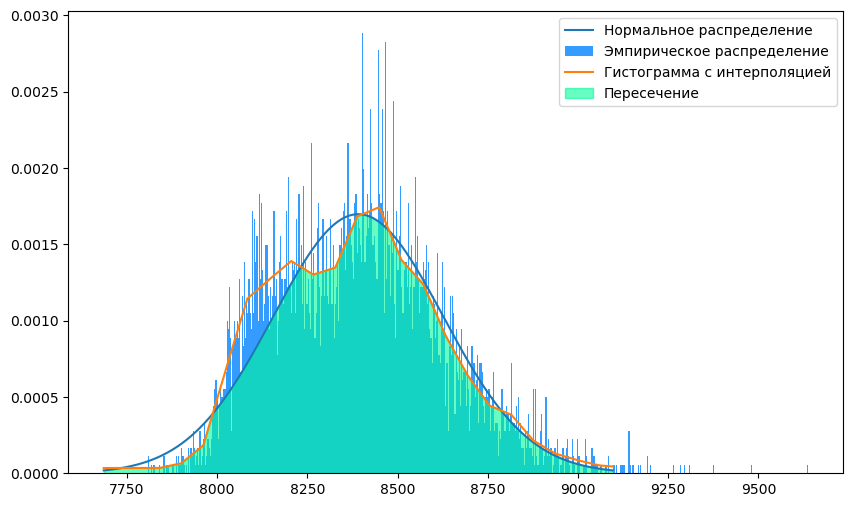

In [55]:
%matplotlib inline
# Вычисление среднего и стандартного отклонения
mean = np.mean(listic250)
std_dev = np.std(listic250)

# Генерация точек для нормального распределения
x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 1000)
y = stats.norm.pdf(x, mean, std_dev)

# Построение гистограммы для списка listic
hist, bin_edges = np.histogram(listic250, bins=30, density=True)

# Пересчет гистограммы в значения плотности
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Интерполяция значений для гистограммы для лучшего сравнения
hist_interp = np.interp(x, bin_centers, hist)

# Рассчитываем минимальные значения для пересечения распределений
intersection = np.minimum(y, hist_interp)

# Объемы
volume_intersection = np.trapz(intersection, x)
volume_union = np.trapz(y, x) + np.trapz(hist_interp, x) - volume_intersection

# Отношение объема пересечения к объему объединения
ratio = volume_intersection / volume_union

print(f'Отношение объема пересечения к объему объединения: {ratio}')

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Нормальное распределение')
plt.hist(listic250, bins=580, color='DodgerBlue', density=True, alpha=0.9, label='Эмпирическое распределение')
plt.plot(x, hist_interp, label='Гистограмма с интерполяцией')
plt.fill_between(x, intersection, color='MediumSpringGreen', alpha=0.6, label='Пересечение')
plt.legend()
plt.show()

<h2 style="color:Blue;">Пересечение гистограммы С НОРМОЙ</h2>

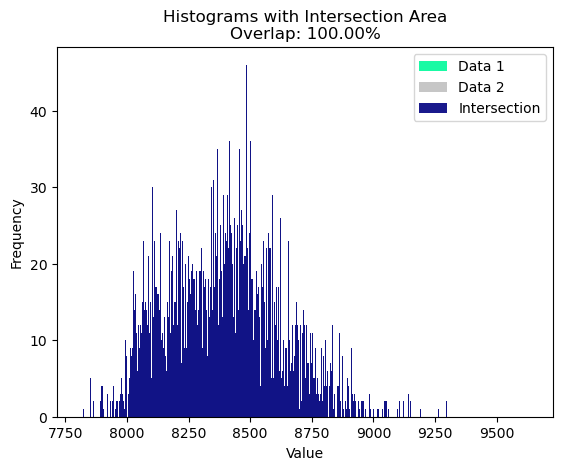

In [57]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def resample_list(data, target_size, seed):
    """Функция для ресемплирования одного списка до размера другого."""
    np.random.seed(seed)  # Установим seed для воспроизводимости
    return np.random.choice(data, target_size, replace=True)

def compute_histogram(data, bins, range):
    """Функция для построения гистограммы."""
    hist, bin_edges = np.histogram(data, bins=bins, range=range)
    return hist, bin_edges

def calculate_overlap_and_union(norm_hist, pat_hist):
    """Функция для вычисления объема пересечения и объема объединения."""
    overlap = np.minimum(norm_hist, pat_hist).sum()
    union = np.maximum(norm_hist, pat_hist).sum()
    return overlap, union

data1 = listic250
data2 = listic250

# Установим значение seed для воспроизводимости
seed = 42

# Ресемплирование списков до одинакового размера
target_size = max(len(data1), len(data2))
data1_resampled = resample_list(data1, target_size, seed)
data2_resampled = resample_list(data2, target_size, seed)

# Определение количества контейнеров (bins) для гистограммы
num_bins = 800

# Определение диапазона данных для гистограммы
data_range = (min(min(data1_resampled), min(data2_resampled)), max(max(data1_resampled), max(data2_resampled)))

# Построение гистограмм
hist1, bin_edges1 = compute_histogram(data1_resampled, bins=num_bins, range=data_range)
hist2, bin_edges2 = compute_histogram(data2_resampled, bins=num_bins, range=data_range)

# Находим минимальные значения гистограмм для зоны пересечения
intersection = np.minimum(hist1, hist2)

# Определяем ширину контейнера (бина)
bin_width = (bin_edges1[1] - bin_edges1[0])

# Вычисление пересечения и объединения гистограмм
overlap, union = calculate_overlap_and_union(hist1, hist2)

# Вычисление показателя степени пересечения в процентах
overlap_percentage = (overlap / union) * 100

# Построение графика
fig, ax = plt.subplots()

# Гистограмма для данных 1
ax.bar(bin_edges1[:-1], hist1, width=bin_width, color='MediumSpringGreen', alpha=0.9, label='Data 1')

# Гистограмма для данных 2
ax.bar(bin_edges2[:-1], hist2, width=bin_width, color='Silver', alpha=0.9, label='Data 2')

# Пересечение гистограмм
ax.bar(bin_edges1[:-1], intersection, width=bin_width, color='Navy', alpha=0.9, label='Intersection')

# Легенда и подписи

ax.legend()
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title(f'Histograms with Intersection Area\nOverlap: {overlap_percentage:.2f}%')

plt.show()

<h1 style="color:red;">PP_700/44(2) - патология</h1>

<h2 style="color:Navy;">1. Создание трехмерноо массива с проверками и преобразованиями при необходимости</h2>

In [58]:
directory = 'D:/AleksandrovTI//PP_700/44(2)'
files = [f for f in os.listdir(directory) if f.endswith('.dcm')]
files.sort()

def read_dicom(file_path):
    dcm = pydicom.dcmread(file_path)
    image = dcm.pixel_array
    
    if 'ImagePositionPatient' in dcm:
        position = dcm.ImagePositionPatient
    elif 'InstanceNumber' in dcm:
        position = [0, 0, dcm.InstanceNumber]  # Выделяем позицию по InstanceNumber
    elif 'SliceLocation' in dcm:
        position = [0, 0, dcm.SliceLocation]  # Выделяем позицию по SliceLocation
    else:
        raise AttributeError(f"File {file_path} lacks position information.")
    
    return image, position

# Читаем все DICOM файлы и получаем их позицию и изображение
slices = [read_dicom(os.path.join(directory, f)) for f in files]
slices.sort(key=lambda s: s[1][2])  # Сортируем по Z координате (или ее альтернативе)

# Создаем объемный массив из нормализованных изображений
volume442 = np.stack([s[0] for s in slices], axis=-1)
print(volume442.shape)

(512, 512, 949)


<h2 style="color:Navy;">2. Визуализация по стандартным проекцим</h2>

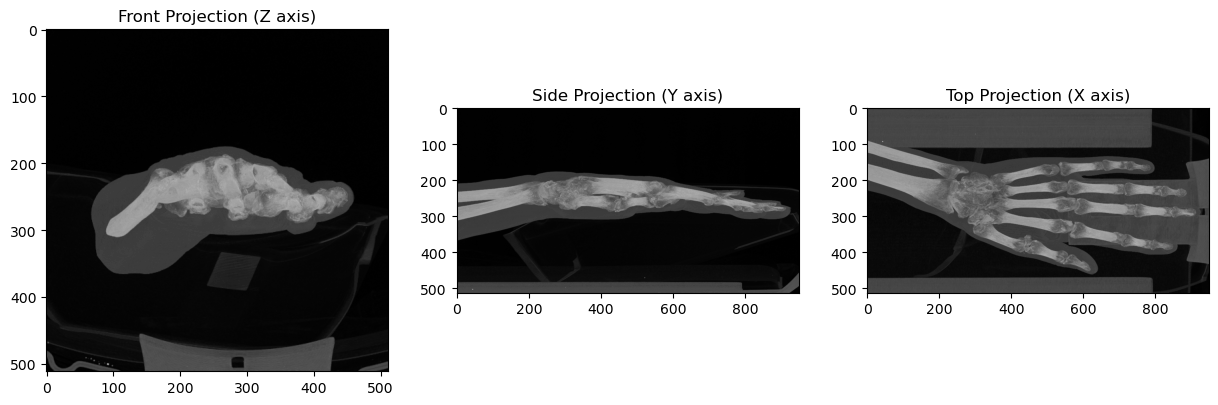

In [59]:
projection_z442 = np.max(volume442, axis=2) # Front projection (по оси Z)
projection_y442 = np.max(volume442, axis=1) # Side projection (по оси Y)
projection_x442 = np.max(volume442, axis=0) # Top projection (по оси X)

fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # Визуализация проекций

axs[0].imshow(projection_z442, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_y442, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_x442, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()

<h2 style="color:Navy;">3. Определение угла между осью исследуемой кости и горизонтом для поворота ПРОЕКЦИИ  X</h2>

<h4 style="color:Navy;">3.1 Сохранение массива в TIFF-файл Top projection (по оси X)</h4>

In [60]:
# Top projection (по оси X)
projection_x442 = np.max(volume442, axis=0)
tifffile.imwrite('01_projection_x442.tiff', projection_x442) # Сохранение массива в TIFF-файл

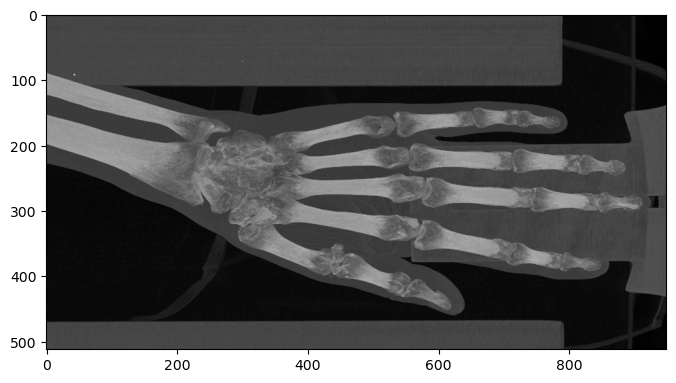

In [61]:
# Отображение изображения
image = tifffile.imread('01_projection_x442.tiff')
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">3.2 Построение угла</h4>

In [65]:
import cv2
import numpy as np

# Функция для изменения яркости и контрастности изображения
def adjust_brightness_contrast(image, brightness=10, contrast=150):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('01_projection_x442.tiff')
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по указанному пути')

# Коррекция яркости и контрастности
image = adjust_brightness_contrast(image, brightness=40, contrast=450)

# Создание холста для отрисовки линий
overlay = image.copy()

# Список для хранения координат кликов
clicks = []
angles = []  # Список для хранения углов
angle = None  # Глобальная переменная для хранения угла

drawing = False

# Функция для записи угла в файл
def save_angle_to_file(angle, filename='angles.txt'):
    with open(filename, 'a') as f:
        f.write(f'{angle:.2f} градусов\n')

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global clicks, drawing, overlay, angle
    
    if event == cv2.EVENT_LBUTTONDOWN:
        clicks.append((x, y))

        if len(clicks) == 2:
            # Построить прямую линию №1, проходящую через ВСЁ изображение
            p1, p2 = clicks
            slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
            intercept = p1[1] - slope * p1[0]

            x_coords = np.array([0, image.shape[1]])
            y_coords = slope * x_coords + intercept
            cv2.line(overlay, (x_coords[0], int(y_coords[0])), (x_coords[1], int(y_coords[1])), (255, 0, 0), 2)
            
            drawing = True

            # Вычисление угла между линией №1 и горизонтом
            angle = np.degrees(np.arctan2(slope, 1))

            # Проверка положения горизонтальной линии относительно линии №1
            if p1[1] < y_coords[0]:
                # Горизонтальная линия выше линии №1
                angle = abs(angle)
            else:
                # Горизонтальная линия ниже линии №1
                angle = -abs(angle)

            angles.append(angle)

            print(f'Угол между линией №1 и горизонтом: {angle:.2f} градусов')

            # Вывод угла на изображение
            cv2.putText(overlay, f'{angle:.2f} degr', (10, image.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            save_angle_to_file(angle)  # Запись угла в файл

        elif len(clicks) == 3:
            # Построить горизонтальную линию через третий клик
            p3 = clicks[2]
            cv2.line(overlay, (0, p3[1]), (image.shape[1], p3[1]), (0, 255, 0), 2)
            print(f'Горизонтальная линия нарисована через точку: {p3}')

# Привязка обработчика событий к окну изображения
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения с наложенными линиями
while True:
    cv2.imshow('Изображение', overlay)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

# Сохранение измененного изображения
cv2.imwrite('02_projection_x442_angle.tiff', overlay)

cv2.destroyAllWindows()

print(f'Углы, сохраненные в программе: {angles}')


Угол между линией №1 и горизонтом: -17.85 градусов
Углы, сохраненные в программе: [-17.854548333919233]


In [66]:
print(angle)

-17.854548333919233


In [67]:
c1 = angle
c1

-17.854548333919233

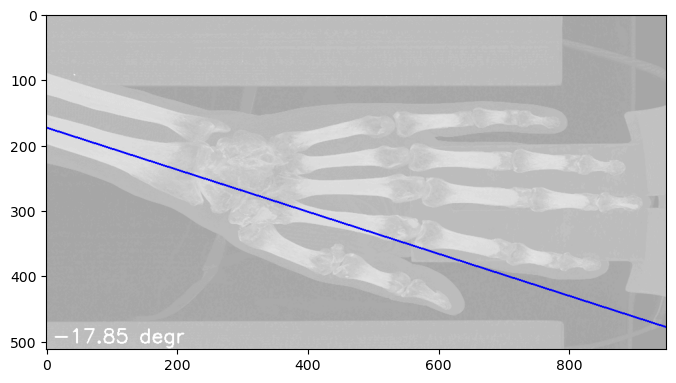

In [68]:
# Отображение изображения
image1 = tifffile.imread('02_projection_x442_angle.tiff')
plt.figure(figsize=(8, 8))
plt.imshow(image1, cmap='gray')
#plt.axis('off')
plt.show()

<h2 style="color:Navy;">4. Поворот плоскостей вокруг оси Z с заданным углом поворота - получение  'rotated_volume442'</h2>

Original volume shape: (512, 512, 949)
Rotated volume shape: (512, 512, 949)


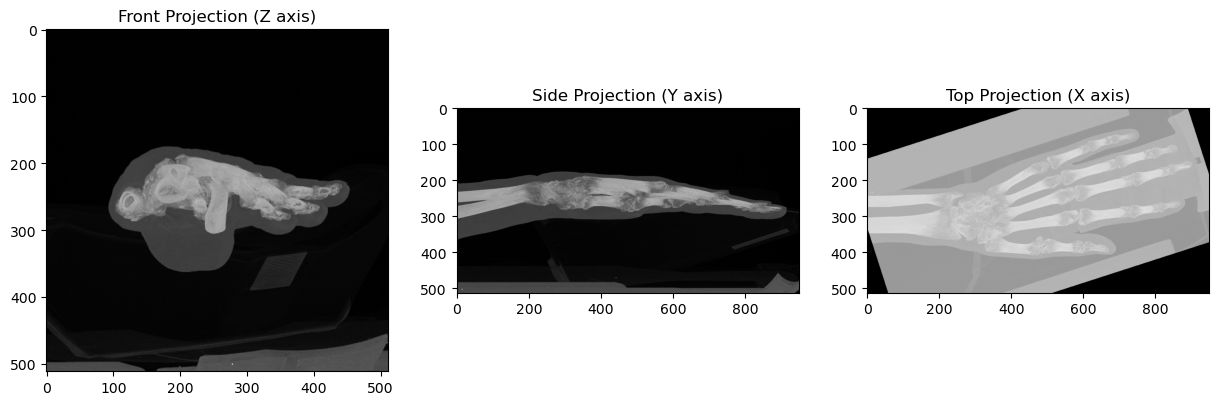

In [69]:
import os
import numpy as np
import pydicom
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

def read_dicom_images(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    files.sort()
    slices = [pydicom.dcmread(f).pixel_array for f in files]
    volume = np.stack(slices, axis=-1)
    return volume

def rotate_volume(volume, angle):
    # Поворот объёма вокруг оси Z
    rotated_volume = rotate(volume, angle, axes=(1, 2), reshape=False)
    return rotated_volume

def get_projections(volume):
    projection_xx = np.flip(np.max(volume, axis=0), axis=1)
    projection_yy = np.flip(np.max(volume, axis=1), axis=1)
    projection_zz = np.flip(np.max(volume, axis=2), axis=1)
    return projection_xx, projection_yy, projection_zz

# Путь к директории с DICOM изображениями
directory = 'D:/AleksandrovTI//PP_700/44(2)'

# Чтение и нормализация изображения
volume442 = read_dicom_images(directory)
#volume_normalized = normalize_images(volume)
print("Original volume shape:", volume442.shape)

# Угол поворота 
angle = c1

# Поворот объёма вокруг оси Z
rotated_volume442 = rotate_volume(volume442, angle)
print("Rotated volume shape:", rotated_volume442.shape)

# Получение проекций после поворота
projection_xr, projection_yr, projection_zr = get_projections(rotated_volume442)

# Визуализация проекций
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(projection_zr, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_yr, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_xr, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()

<h2 style="color:Navy;">5. Определение угла между осью исследуемой кости и горизонтом для поворота ПРОЕКЦИИ Y</h2>

<h4 style="color:Navy;">5.1 Сохранение массива в TIFF-файл Side Projection (Y axis)</h4>

In [70]:
# Side Projection (Y axis)
projection_yr442 = np.max(rotated_volume442, axis=1)
projection_yr442 = np.flip(projection_yr442, axis=1) # ИСПРАВЛЕНИЕ ВЫВОДА ЗЕРКАЛЬНОГО ИЗОБРАЖЕНИЯ
tifffile.imwrite('03_projection_yr442.tiff', projection_yr442)

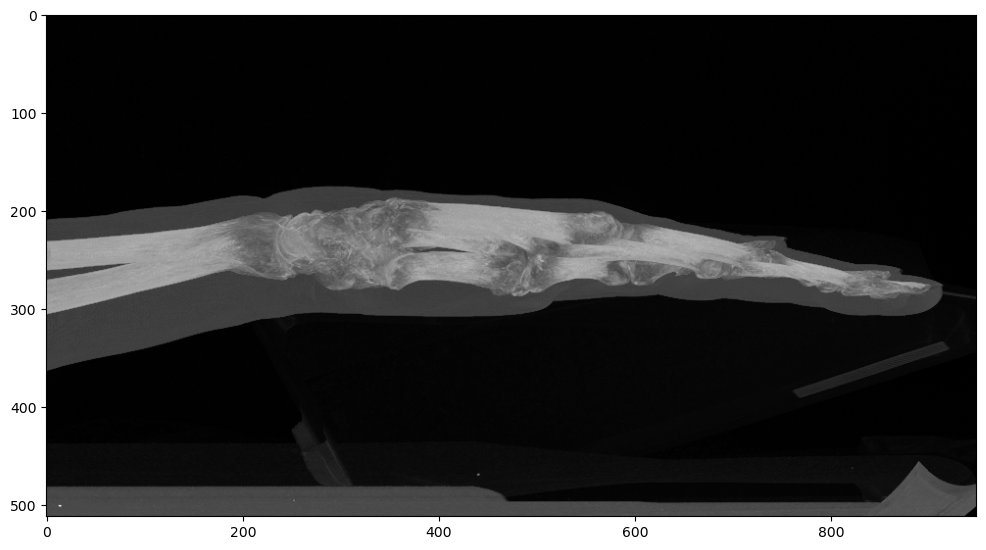

In [71]:
# Отображение изображения
image = tifffile.imread('03_projection_yr442.tiff')
plt.figure(figsize=(12, 12))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">5.2 Построение угла</h4>

In [144]:
import cv2
import numpy as np

# Функция для изменения яркости и контрастности изображения
def adjust_brightness_contrast(image, brightness=10, contrast=150):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('03_projection_yr442.tiff')
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по указанному пути')

# Коррекция яркости и контрастности
image = adjust_brightness_contrast(image, brightness=40, contrast=450)

# Создание холста для отрисовки линий
overlay = image.copy()

# Список для хранения координат кликов
clicks = []
angles = []  # Список для хранения углов
angle = None  # Глобальная переменная для хранения угла

drawing = False

# Функция для записи угла в файл
def save_angle_to_file(angle, filename='angles.txt'):
    with open(filename, 'a') as f:
        f.write(f'{angle:.2f} градусов\n')

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global clicks, drawing, overlay, angle
    
    if event == cv2.EVENT_LBUTTONDOWN:
        clicks.append((x, y))

        if len(clicks) == 2:
            # Построить прямую линию №1, проходящую через ВСЁ изображение
            p1, p2 = clicks
            slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
            intercept = p1[1] - slope * p1[0]

            x_coords = np.array([0, image.shape[1]])
            y_coords = slope * x_coords + intercept
            cv2.line(overlay, (x_coords[0], int(y_coords[0])), (x_coords[1], int(y_coords[1])), (255, 0, 0), 2)
            
            drawing = True

            # Вычисление угла между линией №1 и горизонтом
            angle = np.degrees(np.arctan2(slope, 1))

            # Проверка положения горизонтальной линии относительно линии №1
            if p1[1] < y_coords[0]:
                # Горизонтальная линия выше линии №1
                angle = abs(angle)
            else:
                # Горизонтальная линия ниже линии №1
                angle = -abs(angle)

            angles.append(angle)

            print(f'Угол между линией №1 и горизонтом: {angle:.2f} градусов')

            # Вывод угла на изображение
            cv2.putText(overlay, f'{angle:.2f} degr', (10, image.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            save_angle_to_file(angle)  # Запись угла в файл

        elif len(clicks) == 3:
            # Построить горизонтальную линию через третий клик
            p3 = clicks[2]
            cv2.line(overlay, (0, p3[1]), (image.shape[1], p3[1]), (0, 255, 0), 2)
            print(f'Горизонтальная линия нарисована через точку: {p3}')

# Привязка обработчика событий к окну изображения
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения с наложенными линиями
while True:
    cv2.imshow('Изображение', overlay)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

# Сохранение измененного изображения
cv2.imwrite('04_projection_yr442_angle.tiff', overlay)

cv2.destroyAllWindows()

print(f'Углы, сохраненные в программе: {angles}')


Угол между линией №1 и горизонтом: 1.88 градусов
Углы, сохраненные в программе: [1.882282443010753]


In [145]:
angle

1.882282443010753

In [146]:
d1 = angle
d1

1.882282443010753

In [147]:
c1

-17.854548333919233

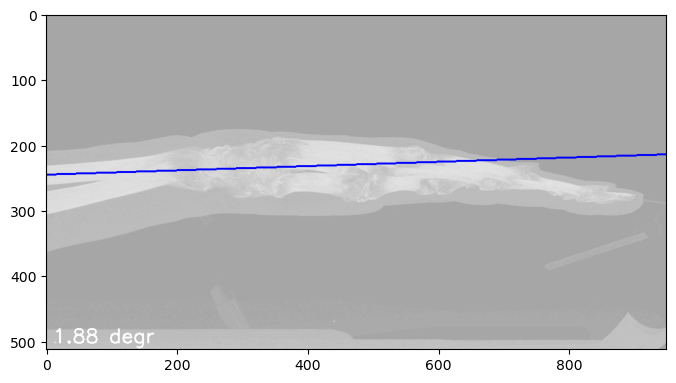

In [148]:
# Отображение изображения
image1 = tifffile.imread('04_projection_yr442_angle.tiff')
plt.figure(figsize=(8, 8))
plt.imshow(image1, cmap='gray')
#plt.axis('off')
plt.show()

<h2 style="color:Navy;">6. Поворот плоскостей вокруг оси Y с заданным углом поворота - получение  'twice_rotated_volume442'</h2>

Rotated volume shape: (512, 512, 949)


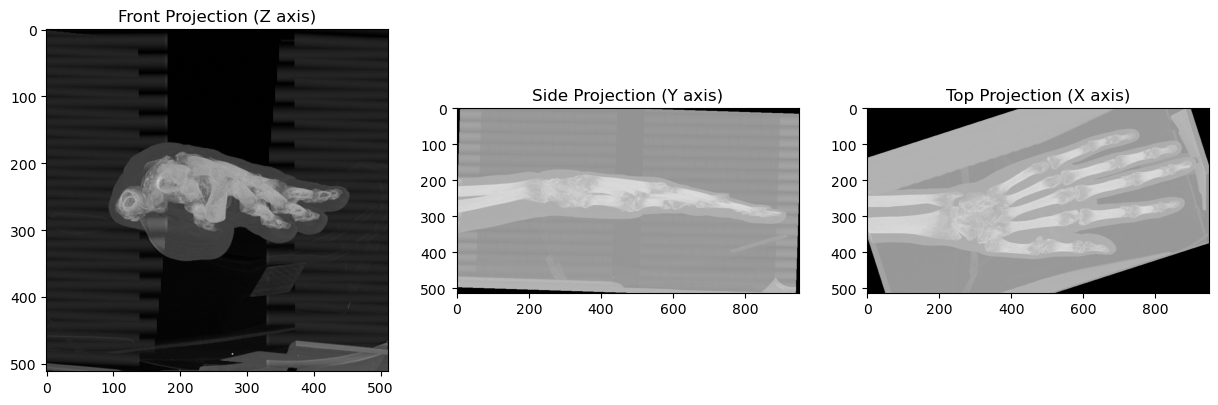

In [149]:
import os
import numpy as np
import pydicom
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

def read_dicom_images(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    files.sort()
    slices = [pydicom.dcmread(f).pixel_array for f in files]
    volume = np.stack(slices, axis=-1)
    return volume

def rotate_volume(volume, angle):
    # Поворот объёма вокруг оси Z
    rotated_volume = rotate(volume, angle, axes=(0, 2), reshape=False)
    return rotated_volume

def get_projections(volume):
    projection_xxx = np.flip(np.max(volume, axis=0), axis=1)
    projection_yyy = np.flip(np.max(volume, axis=1), axis=1)
    projection_zzz = np.flip(np.max(volume, axis=2), axis=1)
    return projection_xxx, projection_yyy, projection_zzz

# Угол поворота 
angle = d1

# Поворот объёма вокруг оси Y
twice_rotated_volume442 = rotate_volume(rotated_volume442, angle)
print("Rotated volume shape:", twice_rotated_volume442.shape)

# Получение проекций после ВТОРОГО поворота
projection_xrr, projection_yrr, projection_zrr = get_projections(twice_rotated_volume442)

# Визуализация проекций
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(projection_zrr, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_yrr, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_xrr, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()

<h2 style="color:Navy;">7. Определение сечений</h2>

<h4 style="color:Navy;">7.1 Вывод проекции Х в twice_rotated_volume152 для определения координаты СРЕДИННОГО сечения искомого массива</h4>

In [150]:
# Top projection (по оси X)
projection_xrr442 = np.max(twice_rotated_volume442, axis=0)
projection_xrr442 = np.flip(projection_xrr442, axis=1)
tifffile.imwrite('05_projection_xrr442.tiff', projection_xrr442)

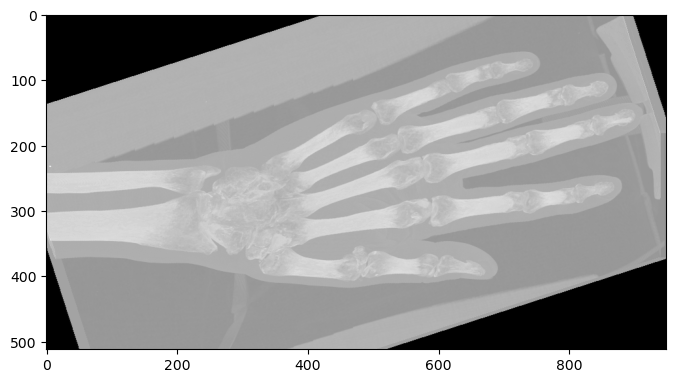

In [151]:
# Отображение изображения
image = tifffile.imread('05_projection_xrr442.tiff')
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">7.2 Определениt координаты СРЕДИННОГО сечения искомого массива</h4>

In [152]:
def adjust_brightness_contrast(image, brightness=50, contrast=50):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('05_projection_xrr442.tiff')

# Функция-обработчик события клика мыши
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Координаты сечения по клику выбранной кости: ({x}, {y})")

# Создание окна и привязка обработчика события
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения
while True:
    cv2.imshow('Изображение', image)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

Координаты сечения по клику выбранной кости: (130, 322)


<h4 style="color:Navy;">7.3 Изображение с ценой деления 10 для уточнения размера интервала третьего измерения искомого массива</h4>

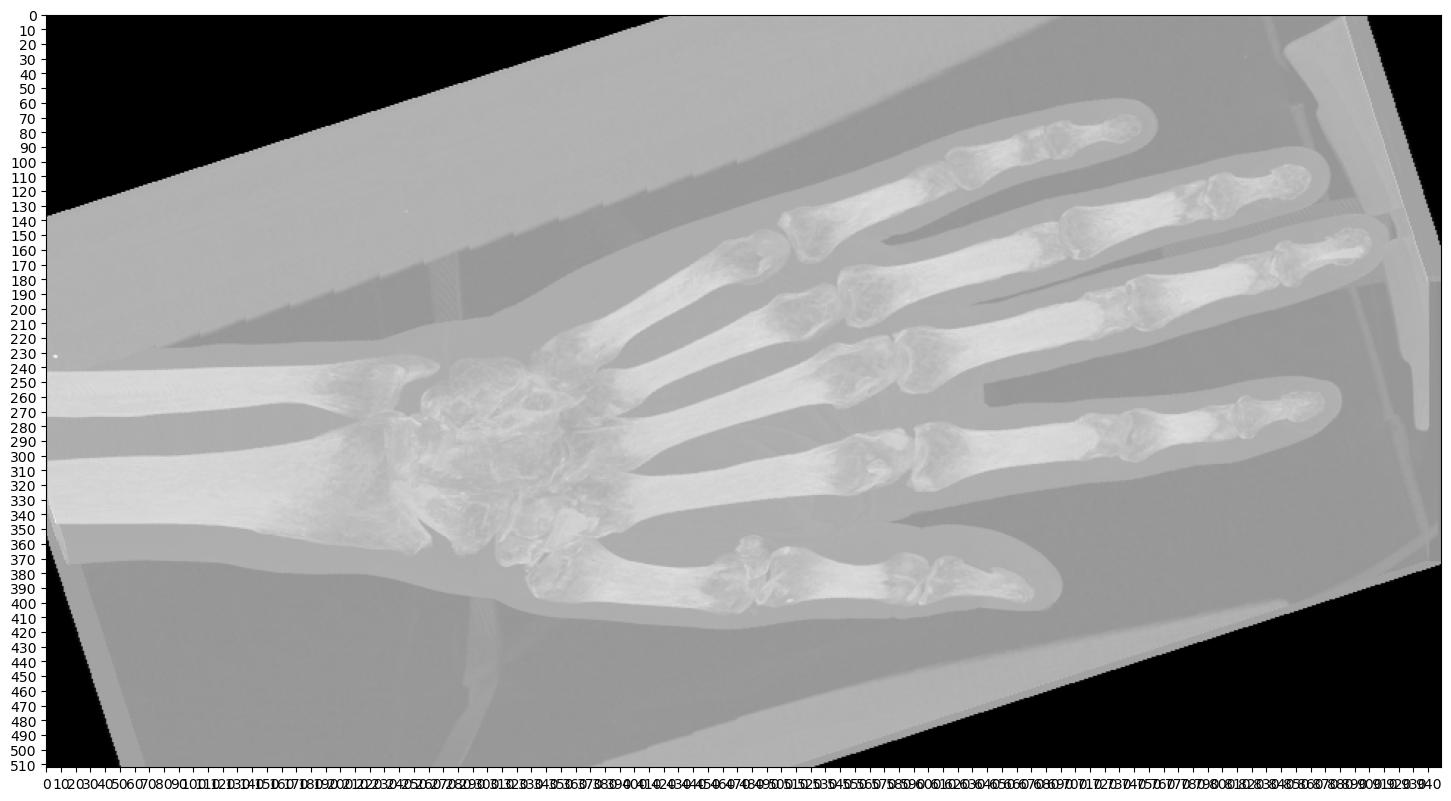

In [153]:
gray_image = mpimg.imread('05_projection_xrr442.tiff')

# Создание фигуры и осей
#fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(18, 12))  # Увеличенный размер холста
# Отображение изображения
ax.imshow(gray_image, cmap='gray', extent=[0, gray_image.shape[1], gray_image.shape[0], 0])

# Настройка тиков по осям x и y с шагом 20
ax.set_xticks(np.arange(0, gray_image.shape[1], 10))
ax.set_yticks(np.arange(0, gray_image.shape[0], 10))

# Показ графика
plt.show()

<h4 style="color:Navy;">7.4 Транспонирование twice_rotated_volume542 в нужную форму для получения искомых массива сечений</h4>

In [154]:
vol = np.transpose(twice_rotated_volume442, (1, 2, 0))
vol.shape

(512, 949, 512)

<h4 style="color:Navy;">7.5 Выбранный размер ОБЪЁМНОГО массива сечений кости</h4>

In [155]:
pict = vol[322]
pict.shape

(949, 512)

In [156]:
pict = np.transpose(pict, (1, 0))
flipped_mono = np.flip(pict, axis=1)
print(f"Исходный массив: {pict.shape}")
print(f"Преобразованный массив: {flipped_mono.shape}")

Исходный массив: (512, 949)
Преобразованный массив: (512, 949)


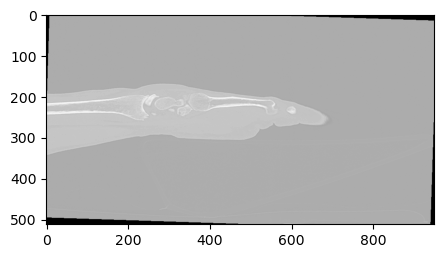

In [157]:
# Сохранение массива в TIFF-файл
tifffile.imwrite('06_projection_xrr442.tiff', flipped_mono)
# Отображение изображения
image = tifffile.imread('06_projection_xrr442.tiff')
plt.figure(figsize=(5, 5))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h2 style="color:Navy;">9. Раскрытие суставных щелей</h2>

<h4 style="color:Navy;">9.1 Ветикальное сечение проекции "projection_yrr" Side Projection (Y axis)</h4>

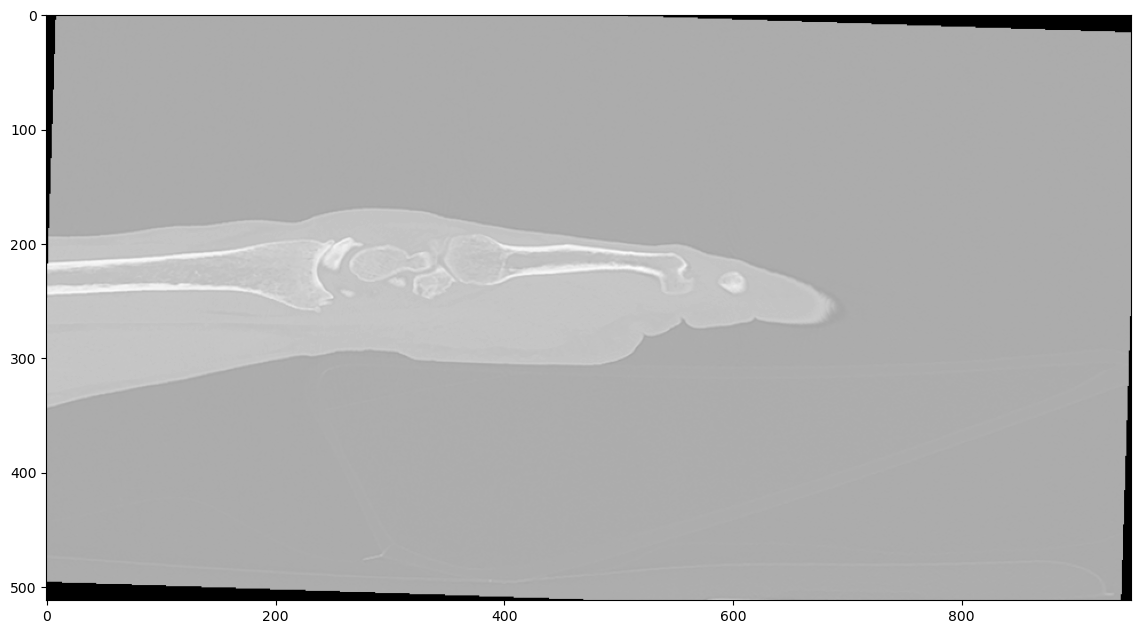

In [158]:
image = tifffile.imread('06_projection_xrr442.tiff')
plt.figure(figsize=(14, 14))
plt.imshow(image, cmap='gray')
#plt.axis('off')
plt.show()

<h4 style="color:Navy;">9.2 Определение на ветикальном сечении проекции "projection_yrr" Side Projection координату последующего сечения Z плоскостью</h4>

In [159]:
def adjust_brightness_contrast(image, brightness=50, contrast=50):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('06_projection_xrr442.tiff')
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по пути')

# Коррекция яркости и контрастности
image = adjust_brightness_contrast(image, brightness=30, contrast=500)

# Функция-обработчик события клика мыши
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Координаты сечения по клику выбранной кости: ({x}, {y})")

# Создание окна и привязка обработчика события
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения
while True:
    cv2.imshow('Изображение', image)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

Координаты сечения по клику выбранной кости: (100, 226)


<h4 style="color:Navy;">9.3 Сечение массива второго поворота "twice_rotated_volume152" плоскостью на высоте 216 с вариантами</h4>

In [160]:
twice_rotated_volume442.shape

(512, 512, 949)

In [161]:
voll = np.transpose(twice_rotated_volume442, (0, 1, 2))
voll.shape

(512, 512, 949)

In [162]:
pictt4 = twice_rotated_volume442[224]
# Зеркальное отражение изображения слева направо
flipped_pictt4 = np.flip(pictt4, axis=0)
flipped_pictt44 = np.transpose(flipped_pictt4, (1, 0))

In [163]:
pictt5 = twice_rotated_volume442[226]
# Зеркальное отражение изображения слева направо
flipped_pictt5 = np.flip(pictt5, axis=0)
flipped_pictt55 = np.transpose(flipped_pictt5, (1, 0))

In [164]:
pictt6 = twice_rotated_volume442[228]
# Зеркальное отражение изображения слева направо
flipped_pictt6 = np.flip(pictt6, axis=0)
flipped_pictt66 = np.transpose(flipped_pictt6, (1, 0))

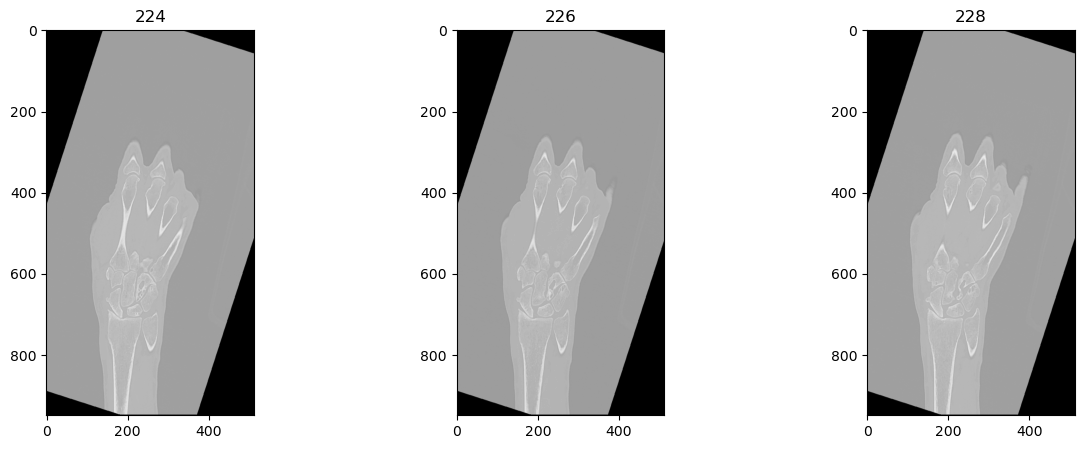

In [165]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # Визуализация проекций

axs[0].imshow(flipped_pictt44, cmap='gray')
axs[0].set_title('224')

axs[1].imshow(flipped_pictt55, cmap='gray')
axs[1].set_title('226')

axs[2].imshow(flipped_pictt66, cmap='gray')
axs[2].set_title('228')

plt.show()

<h4 style="color:DarkSlateGray;">9.4 Обрезка изображения для черно-белого изображения</h4>

In [166]:
tifffile.imwrite('15_224_442.tiff', flipped_pictt44) # Сохранение массива в TIFF-файл
tifffile.imwrite('15_226_442.tiff', flipped_pictt55) # Сохранение массива в TIFF-файл
tifffile.imwrite('15_228_442.tiff', flipped_pictt66) # Сохранение массива в TIFF-файл

#### 224

In [167]:
image = Image.open('15_224_442.tiff')

# размеры для обрезки
left = 125
top = 550
right = 150
bottom = 50

cropped_image = image.crop((left, top, image.width - right, image.height - bottom))

cropped_image.save('16_224_442_bw.tiff')

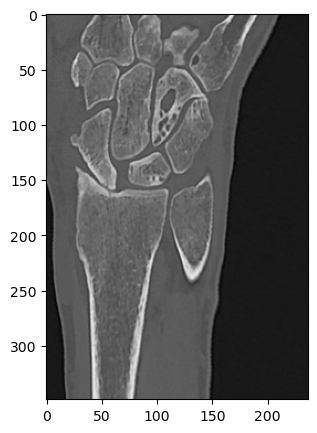

In [168]:
%matplotlib inline
gray_image152 = Image.open('16_224_442_bw.tiff')

plt.figure(figsize=(5, 5)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
#plt.axis('off')
plt.show()

#### 226

In [169]:
image = Image.open('15_226_442.tiff')

# размеры для обрезки
left = 125
top = 550
right = 150
bottom = 50

cropped_image = image.crop((left, top, image.width - right, image.height - bottom))

cropped_image.save('16_226_442_bw.tiff')

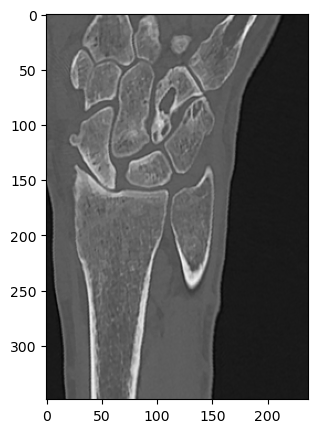

In [176]:
%matplotlib inline
gray_image1521 = Image.open('16_226_442_bw.tiff')

plt.figure(figsize=(5, 5)) # Отображение изображения в оттенках серого
plt.imshow(gray_image1521, cmap='gray')
#plt.axis('off')
plt.show()

In [178]:
gray_image1521 = np.array(gray_image1521)
gray_image1521.shape

(349, 237)

#### 228

In [171]:
image = Image.open('15_228_442.tiff')

# размеры для обрезки
left = 125
top = 550
right = 150
bottom = 50

cropped_image = image.crop((left, top, image.width - right, image.height - bottom))

cropped_image.save('16_228_442_bw.tiff')

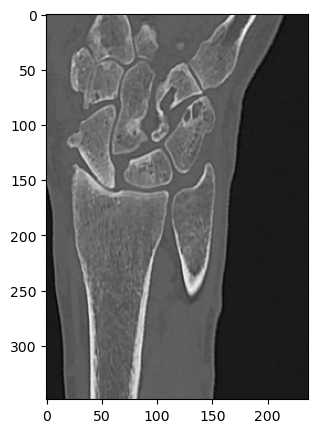

In [172]:
%matplotlib inline
gray_image152 = Image.open('16_228_442_bw.tiff')

plt.figure(figsize=(5, 5)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
#plt.axis('off')
plt.show()

In [173]:
imagettt = tifffile.imread('16_226_442_bw.tiff')

In [174]:
print(imagettt.min())
print(imagettt.max())

6797
10761


<h2 style="color:Navy;">11. Лучевая</h2>

In [182]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from PIL import Image, ImageDraw
import pandas as pd
import matplotlib
import tifffile

matplotlib.use('TkAgg')  # Используйте TkAgg backend
from matplotlib.backend_bases import MouseButton

df1 = pd.DataFrame(columns=['pixels_inside_curve'])

image_path = '16_226_442_bw.tiff'  # Путь к изображению
image_array = tifffile.imread(image_path)  # Чтение изображения в numpy массив
image_array = image_array.astype(np.int32)
# Преобразование numpy массива в объект PIL Image для дальнейшего использования
image = Image.fromarray(image_array).convert("RGBA")

# Определение размера изображения
height, width = [349,237]

# список для хранения точек
points = []

def onclick(event):
    line_image = create_line_image()
    save_combined_image(line_image)

# Обработчик кликов
def onclick(event):
    global points
    if event.button == MouseButton.LEFT:
        # Добавление точки в список
        points.append([event.xdata, event.ydata])
        
        # Отображение точки на изображении
        ax.plot(event.xdata, event.ydata, 'ro', markersize=3)
        fig.canvas.draw()
        
        # Когда было выбрано 31 точек или больше, нарисовать кривую линию
        if len(points) == 41:
            if points[0] != points[-1]:
                points.append(points[0])
            line_image = draw_spline(points)  # Теперь передаем line_image
            save_combined_image(line_image)
            save_line_image(line_image)  # Добавляем этот вызов
            save_internal_pixels_list(points, width, height)  # Передаем ширину и высоту
            fig.canvas.mpl_disconnect(cid)

# Функция для рисования кривой линии
def draw_spline(points):
    points = np.array(points)
    x = points[:, 0]
    y = points[:, 1]
    
    # Используем сплайны для плавной линии через контрольные точки
    tck, u = splprep([x, y], s=0)
    u_new = np.linspace(u.min(), u.max(), 1000)
    x_new, y_new = splev(u_new, tck, ext=0)
    
    ax.plot(x_new, y_new, 'r-', lw=1.2)  # Рисование линии
    fig.canvas.draw()

    # Создаем пустое изображение для линии
    line_image = Image.new("RGBA", (width, height), (0, 0, 0, 0))
    save_combined_image(line_image)
    draw = ImageDraw.Draw(line_image)
    line_points = list(zip(x_new, y_new))
    draw.line(line_points, fill=(255, 0, 0, 255), width=1)
    return line_image

# Функция для сохранения изображения с нанесённой линией
def save_combined_image(line_image):
    # Копируем исходное изображение
    combined_image = image.copy()
    combined_image = Image.alpha_composite(combined_image, line_image)
    combined_image.save("16_226_442_line_bw.tiff")
    #print("Изображение сохранено как 16_256_152_gilula_and_1_line.png")
    
# Функция для сохранения только линии в отдельный файл
def save_line_image(line_image):
    line_image.save("sect_line_only.tiff")
    #print("Изображение линии сохранено как first_line_only.png")

# Функция для сохранения списка пикселей внутри замкнутой кривой линии
def save_internal_pixels_list(points, width, height):
    mask = Image.new("L", (width, height), 0)
    points = [(int(p[0]), int(p[1])) for p in points]
    ImageDraw.Draw(mask).polygon(points, outline=1, fill=1)
    mask = np.array(mask)
    
    internal_pixels = image_array[mask == 1]
    
    # Добавление списка пикселей в DataFrame
    df1.loc[len(df1)] = [internal_pixels.tolist()]
    print("Пиксели внутри замкнутой кривой линии добавлены в DataFrame")
    print(df1)

# Создание фигуры и отображение изображения
fig, ax = plt.subplots()
ax.imshow(image_array)

# Привязка обработчика кликов
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# Запуск обработки событий и отображение окна
plt.show()

Пиксели внутри замкнутой кривой линии добавлены в DataFrame
                                 pixels_inside_curve
0  [8612, 8619, 8636, 8583, 8574, 8626, 8546, 853...


In [183]:
df1

pixels_inside_curve
0  [8612, 8619, 8636, 8583, 8574, 8626, 8546, 853...

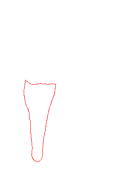

In [184]:
%matplotlib inline
gray_image152 = mpimg.imread('16_226_442_line_bw.tiff')
plt.figure(figsize=(2, 2)) # Отображение изображения в оттенках серого
plt.imshow(gray_image152, cmap='gray')
plt.axis('off')
plt.show()

<h3 style="color:blue;">4.2 Количество и значения пикселей на ограниченном линией участке</h3>

In [185]:
# Каличество пикселей
len(df1.iloc[0,0])

7385

In [187]:
# СПИСОК
listic442 = df1.iloc[0,0] # Список элементов
print(listic442[0:10])
print(min(listic442))
print(max(listic442))

[8612, 8619, 8636, 8583, 8574, 8626, 8546, 8533, 8563, 8557]
7862
9053


In [188]:
import pickle
with open('listic442.pkl', 'wb') as f:
    pickle.dump(listic442, f)

In [189]:
import pickle
# Загрузка из pickle-файла
with open('listic442.pkl', 'rb') as f:
    listic442 = pickle.load(f)

<h2 style="color:Blue;">12.1 Представление распределения вырезанной части изображения listic442</h2>

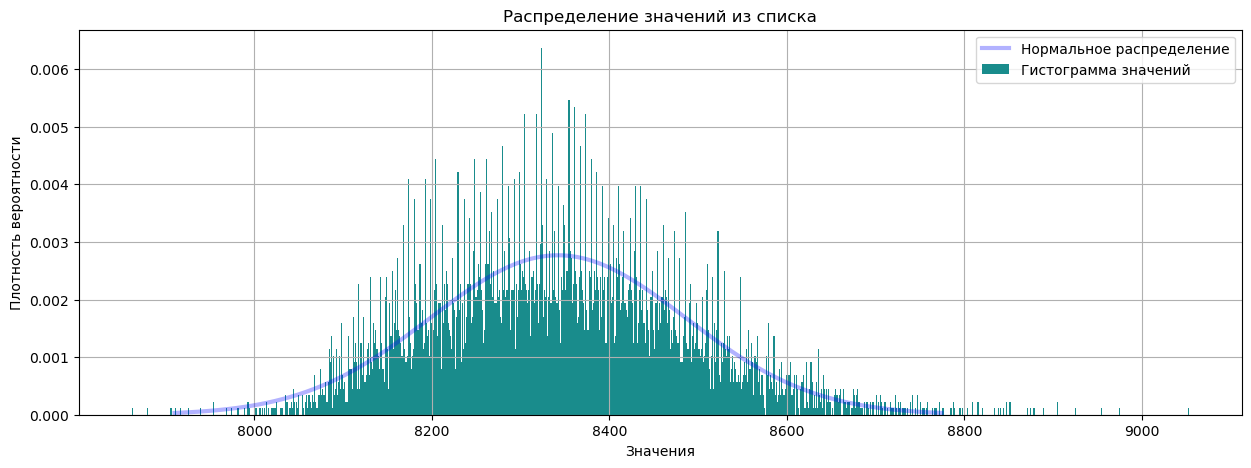

Эксцесс  0.21729367762856366
Асимметрия  0.34880883352501546
Среднее значение пикселей: 8342.160595802303
Минимальное значение пикселей: 7862
Минимальное значение пикселей: 9053
Три наиболее часто встречающихся значения:
Значение: 8323, Частота: 35
Значение: 8350, Частота: 29
Значение: 8325, Частота: 29


In [190]:
from collections import Counter
from scipy.stats import kurtosis
from scipy.stats import skew
import statistics
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
# Вычисление среднего и стандартного отклонения
mean = np.mean(listic442) ######################################################################
std_dev = np.std(listic442) ###############################################################################

# Генерация точек для построения нормального распределения
x = np.linspace(mean -3*std_dev, mean + 3*std_dev, 100)
y = stats.norm.pdf(x, mean, std_dev)


# Построение графика
plt.figure(figsize=(15, 5))
plt.plot(x, y, linewidth=3, color='b', label='Нормальное распределение', alpha=0.3)
plt.hist(listic442, density=True, bins=1000, alpha=0.9, color='Teal', label='Гистограмма значений') ############################


plt.title('Распределение значений из списка')
plt.xlabel('Значения')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid()
plt.show()
print("Эксцесс ", kurtosis(listic442))######################################################
print("Асимметрия ", skew(listic442))####################################################

average = statistics.mean(listic442) #####################################################
print(f'Среднее значение пикселей: {average}') 

mi = min(listic442)##################################################################
print(f'Минимальное значение пикселей: {mi}') 
ma = max(listic442)###################################################################
print(f'Минимальное значение пикселей: {ma}') 

count = Counter(listic442)  ##################################################################
# Получение трех наиболее распространенных значений и их частоты
most_common_three = count.most_common(3)
print("Три наиболее часто встречающихся значения:")
for value, freq in most_common_three:
    print(f'Значение: {value}, Частота: {freq}')


<h4 style="color:Blue;">Уникальных значкеий в списке</h4>

In [191]:
unique_values442 = set(listic442)
len(unique_values442)

736

<h4 style="color:Blue;">Отношение объема пересечения к объему объединения гистограммы и её нормального распределения (unhealthy)</h4>

Отношение объема пересечения к объему объединения: 0.9268977151998687


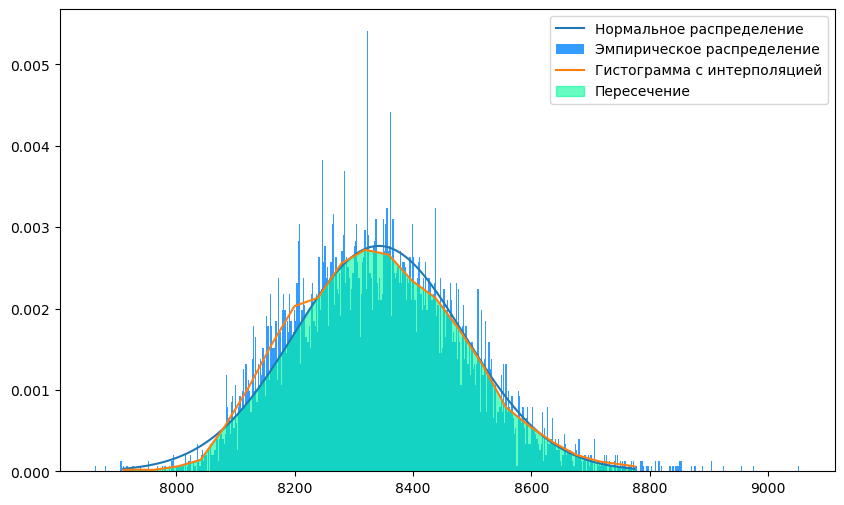

In [192]:
%matplotlib inline
# Вычисление среднего и стандартного отклонения
mean = np.mean(listic442)
std_dev = np.std(listic442)

# Генерация точек для нормального распределения
x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 1000)
y = stats.norm.pdf(x, mean, std_dev)

# Построение гистограммы для списка listic
hist, bin_edges = np.histogram(listic442, bins=30, density=True)

# Пересчет гистограммы в значения плотности
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Интерполяция значений для гистограммы для лучшего сравнения
hist_interp = np.interp(x, bin_centers, hist)

# Рассчитываем минимальные значения для пересечения распределений
intersection = np.minimum(y, hist_interp)

# Объемы
volume_intersection = np.trapz(intersection, x)
volume_union = np.trapz(y, x) + np.trapz(hist_interp, x) - volume_intersection

# Отношение объема пересечения к объему объединения
ratio = volume_intersection / volume_union

print(f'Отношение объема пересечения к объему объединения: {ratio}')

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Нормальное распределение')
plt.hist(listic442, bins=580, color='DodgerBlue', density=True, alpha=0.9, label='Эмпирическое распределение')
plt.plot(x, hist_interp, label='Гистограмма с интерполяцией')
plt.fill_between(x, intersection, color='MediumSpringGreen', alpha=0.6, label='Пересечение')
plt.legend()
plt.show()

<h2 style="color:Blue;">Пересечение гистограммы С НОРМОЙ</h2>

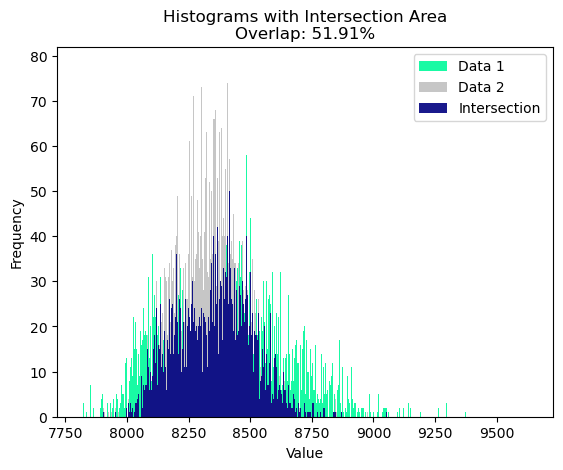

In [193]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def resample_list(data, target_size, seed):
    """Функция для ресемплирования одного списка до размера другого."""
    np.random.seed(seed)  # Установим seed для воспроизводимости
    return np.random.choice(data, target_size, replace=True)

def compute_histogram(data, bins, range):
    """Функция для построения гистограммы."""
    hist, bin_edges = np.histogram(data, bins=bins, range=range)
    return hist, bin_edges

def calculate_overlap_and_union(norm_hist, pat_hist):
    """Функция для вычисления объема пересечения и объема объединения."""
    overlap = np.minimum(norm_hist, pat_hist).sum()
    union = np.maximum(norm_hist, pat_hist).sum()
    return overlap, union

data1 = listic250
data2 = listic442

# Установим значение seed для воспроизводимости
seed = 42

# Ресемплирование списков до одинакового размера
target_size = max(len(data1), len(data2))
data1_resampled = resample_list(data1, target_size, seed)
data2_resampled = resample_list(data2, target_size, seed)

# Определение количества контейнеров (bins) для гистограммы
num_bins = 800

# Определение диапазона данных для гистограммы
data_range = (min(min(data1_resampled), min(data2_resampled)), max(max(data1_resampled), max(data2_resampled)))

# Построение гистограмм
hist1, bin_edges1 = compute_histogram(data1_resampled, bins=num_bins, range=data_range)
hist2, bin_edges2 = compute_histogram(data2_resampled, bins=num_bins, range=data_range)

# Находим минимальные значения гистограмм для зоны пересечения
intersection = np.minimum(hist1, hist2)

# Определяем ширину контейнера (бина)
bin_width = (bin_edges1[1] - bin_edges1[0])

# Вычисление пересечения и объединения гистограмм
overlap, union = calculate_overlap_and_union(hist1, hist2)

# Вычисление показателя степени пересечения в процентах
overlap_percentage = (overlap / union) * 100

# Построение графика
fig, ax = plt.subplots()

# Гистограмма для данных 1
ax.bar(bin_edges1[:-1], hist1, width=bin_width, color='MediumSpringGreen', alpha=0.9, label='Data 1')

# Гистограмма для данных 2
ax.bar(bin_edges2[:-1], hist2, width=bin_width, color='Silver', alpha=0.9, label='Data 2')

# Пересечение гистограмм
ax.bar(bin_edges1[:-1], intersection, width=bin_width, color='Navy', alpha=0.9, label='Intersection')

# Легенда и подписи

ax.legend()
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title(f'Histograms with Intersection Area\nOverlap: {overlap_percentage:.2f}%')

plt.show()